In [1]:
import sys
import os
import numpy as np
# os.chdir(r'D:\Jay PhD\Code\data_fitting\data')
sys.path.append(r'C:\Program Files\Keysight\Labber\Script')
import Labber
import matplotlib.pyplot as plt
np.bool = bool
np.float = np.float64

In [2]:
shot = r"D:\Jay PhD\5q data\shot\q1 single shot 30000 gain 1.5us.hdf5"
shot = Labber.LogFile(shot)

In [3]:
g = shot.getData()[0]
e = shot.getData()[1]

In [4]:
Ig, Qg = g.real, g.imag
Ie, Qe = e.real, e.imag

In [5]:
data={}
data["Ig"] = Ig
data["Qg"] = Qg
data["Ie"] = Ie
data["Qe"] = Qe

# new

In [6]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import fitting as fitter

# Use np.hist and plt.plot to accomplish plt.hist with less memory usage
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
linestyle_cycle = ["solid", "dashed", "dotted", "dashdot"]
marker_cycle = ["o", "*", "s", "^"]


def plot_hist(
    data,
    bins,
    ax=None,
    xlims=None,
    color=None,
    linestyle=None,
    label=None,
    alpha=None,
    normalize=True,
):
    if color is None:
        color_cycle = cycle(default_colors)
        color = next(color_cycle)
    hist_data, bin_edges = np.histogram(data, bins=bins, range=xlims)
    if normalize:
        hist_data = hist_data / hist_data.sum()
    for i in range(len(hist_data)):
        if i > 0:
            label = None
        ax.plot(
            [bin_edges[i], bin_edges[i + 1]],
            [hist_data[i], hist_data[i]],
            color=color,
            linestyle=linestyle,
            label=label,
            alpha=alpha,
            linewidth=0.9,
        )
        if i < len(hist_data) - 1:
            ax.plot(
                [bin_edges[i + 1], bin_edges[i + 1]],
                [hist_data[i], hist_data[i + 1]],
                color=color,
                linestyle=linestyle,
                alpha=alpha,
                linewidth=0.9,
            )
    ax.relim()
    ax.set_ylim((0, None))
    return hist_data, bin_edges


# ===================================================================== #
def general_hist(
    iqshots,
    state_labels,
    g_states,
    e_states,
    e_label="e",
    check_qubit_label=None,
    numbins=200,
    amplitude_mode=False,
    ps_threshold=None,
    theta=None,
    plot=True,
    verbose=True,
    fid_avg=False,
    fit=False,
    fitparams=None,
    normalize=True,
    title=None,
    export=False,
    check_qnd=False,
):
    """
    span: histogram limit is the mean +/- span
    theta given and returned in deg
    assume iqshots = [(idata, qdata)]*len(check_states), idata=[... *num_shots]*num_qubits_sample
    g_states are indices to the check_states to categorize as "g" (the rest are "e")
    e_label: label to put on the cumulative counts for the "e" state, i.e. the state relative to which the angle/fidelity is calculated
    check_qubit_label: label to indicate which qubit is being measured
    fid_avg: determines the method of calculating the fidelity (whether to average the mis-categorized e/g or count the total number of miscategorized over total counts)
    normalize: normalizes counts by total counts
    """
    if numbins is None:
        numbins = 200

    # total histograms for shots listed as g or e
    Ig_tot = []
    Qg_tot = []
    Ie_tot = []
    Qe_tot = []

    # the actual total histograms of everything
    Ig_tot_tot = []
    Qg_tot_tot = []
    Ie_tot_tot = []
    Qe_tot_tot = []
    for check_i, data_check in enumerate(iqshots):
        I, Q = data_check
        Ig_tot_tot = np.concatenate((Ig_tot_tot, I))
        Qg_tot_tot = np.concatenate((Qg_tot_tot, Q))
        Ie_tot_tot = np.concatenate((Ig_tot_tot, I))
        Qe_tot_tot = np.concatenate((Qg_tot_tot, Q))
        if check_i in g_states:
            Ig_tot = np.concatenate((Ig_tot, I))
            Qg_tot = np.concatenate((Qg_tot, Q))
        elif check_i in e_states:
            Ie_tot = np.concatenate((Ig_tot, I))
            Qe_tot = np.concatenate((Qg_tot, Q))

    if not amplitude_mode:
        """Compute the rotation angle"""
        if theta is None:
            xg, yg = np.average(Ig_tot), np.average(Qg_tot)
            xe, ye = np.average(Ie_tot), np.average(Qe_tot)
            theta = -np.arctan2((ye - yg), (xe - xg))
        else:
            theta *= np.pi / 180
        Ig_tot_tot_new = Ig_tot_tot * \
            np.cos(theta) - Qg_tot_tot * np.sin(theta)
        Qg_tot_tot_new = Ig_tot_tot * \
            np.sin(theta) + Qg_tot_tot * np.cos(theta)
        Ie_tot_tot_new = Ie_tot_tot * \
            np.cos(theta) - Qe_tot_tot * np.sin(theta)
        Qe_tot_tot_new = Ie_tot_tot * \
            np.sin(theta) + Qe_tot_tot * np.cos(theta)
        I_tot_tot_new = np.concatenate((Ie_tot_tot_new, Ig_tot_tot_new))
        span = (np.max(I_tot_tot_new) - np.min(I_tot_tot_new)) / 2
        midpoint = (np.max(I_tot_tot_new) + np.min(I_tot_tot_new)) / 2
    else:
        theta = 0
        amp_g_tot_tot = np.abs(Ig_tot_tot + 1j * Qg_tot_tot)
        amp_e_tot_tot = np.abs(Ie_tot_tot + 1j * Qe_tot_tot)
        amp_tot_tot = np.concatenate((amp_g_tot_tot, amp_e_tot_tot))
        span = (np.max(amp_tot_tot) - np.min(amp_tot_tot)) / 2
        midpoint = (np.max(amp_tot_tot) + np.min(amp_tot_tot)) / 2
    xlims = [midpoint - span, midpoint + span]

    if plot:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
        if title is None:
            title = f"Readout Fidelity" + \
                (f" on Q{check_qubit_label}" if check_qubit_label is not None else "")
        fig.suptitle(title)
        fig.tight_layout()
        axs[0, 0].set_ylabel("Q [ADC levels]", fontsize=11)
        axs[0, 0].set_title("Unrotated", fontsize=13)
        axs[0, 0].axis("equal")
        axs[0, 0].tick_params(axis="both", which="major", labelsize=10)
        axs[0, 0].set_xlabel("I [ADC levels]", fontsize=11)

        axs[0, 1].axis("equal")
        axs[0, 1].tick_params(axis="both", which="major", labelsize=10)
        axs[0, 1].set_xlabel("I [ADC levels]", fontsize=11)

        threshold_axis = "I" if not amplitude_mode else "Amplitude"
        axs[1, 0].set_ylabel("Counts", fontsize=12)
        axs[1, 0].set_xlabel(f"{threshold_axis} [ADC levels]", fontsize=11)
        axs[1, 0].tick_params(axis="both", which="major", labelsize=10)

        axs[1, 1].set_title("Cumulative Counts", fontsize=13)
        axs[1, 1].set_xlabel(f"{threshold_axis} [ADC levels]", fontsize=11)
        axs[1, 1].tick_params(axis="both", which="major", labelsize=10)
        plt.subplots_adjust(hspace=0.35, wspace=0.15)

    y_max = 0
    n_tot_g = [0] * numbins
    n_tot_e = [0] * numbins
    if fit:
        popts = [None] * len(state_labels)
        pcovs = [None] * len(state_labels)

    """
    Loop over check states
    """
    y_max = 0
    for check_i, data_check in enumerate(iqshots):
        state_label = state_labels[check_i]

        I, Q = data_check
        amp = np.abs(I + 1j * Q)

        xavg, yavg, amp_avg = np.average(I), np.average(Q), np.average(amp)

        """Rotate the IQ data"""
        I_new = I * np.cos(theta) - Q * np.sin(theta)
        Q_new = I * np.sin(theta) + Q * np.cos(theta)

        """New means of each blob"""
        xavg_new, yavg_new = np.average(I_new), np.average(Q_new)

        if verbose:
            print(state_label, "unrotated averages:")
            if not amplitude_mode:
                print(
                    f"I {xavg} +/- {np.std(I)} \t Q {yavg} +/- {np.std(Q)} \t Amp {amp_avg} +/- {np.std(amp)}")
                print(f"Rotated (theta={theta}):")
                print(
                    f"I {xavg_new} +/- {np.std(I_new)} \t Q {yavg_new} +/- {np.std(Q_new)} \t Amp {np.abs(xavg_new+1j*yavg_new)} +/- {np.std(amp)}"
                )
            else:
                print(f"Amps {amp_avg} +/- {np.std(amp)}")

        if plot:
            axs[0, 0].scatter(
                I,
                Q,
                label=state_label,
                color=default_colors[check_i % len(default_colors)],
                marker=".",
                edgecolor="None",
                alpha=0.3,
            )
            axs[0, 0].plot(
                [xavg],
                [yavg],
                color="k",
                linestyle=":",
                marker="o",
                markerfacecolor=default_colors[check_i % len(default_colors)],
                markersize=5,
            )

            axs[0, 1].scatter(
                I_new,
                Q_new,
                label=state_label,
                color=default_colors[check_i % len(default_colors)],
                marker=".",
                edgecolor="None",
                alpha=0.3,
            )
            axs[0, 1].plot(
                [xavg_new],
                [yavg_new],
                color="k",
                linestyle=":",
                marker="o",
                markerfacecolor=default_colors[check_i % len(default_colors)],
                markersize=5,
            )

            if check_i in g_states or check_i in e_states:
                linestyle = linestyle_cycle[0]
            else:
                linestyle = linestyle_cycle[1]

            # n, bins, p = axs[1,0].hist(I_new, bins=numbins, range=xlims, color=default_colors[check_i % len(default_colors)], label=label, histtype='step', linestyle=linestyle)
            n, bins = plot_hist(
                I_new if not amplitude_mode else amp,
                bins=numbins,
                ax=axs[1, 0],
                xlims=xlims,
                color=default_colors[check_i % len(default_colors)],
                label=state_label,
                linestyle=linestyle,
                normalize=normalize,
            )
            y_max = max(y_max, max(n))
            axs[1, 0].set_ylim((0, y_max * 1.1))
            # n, bins = np.histogram(I_new, bins=numbins, range=xlims)
            # axs[1,0].plot(bins[:-1], n/n.sum(), color=default_colors[check_i % len(default_colors)], linestyle=linestyle)

            axs[1, 1].plot(
                bins[:-1],
                np.cumsum(n) / n.sum(),
                color=default_colors[check_i % len(default_colors)],
                linestyle=linestyle,
            )

        else:  # just getting the n, bins for data processing
            n, bins = np.histogram(
                I_new if not amplitude_mode else amp, bins=numbins, range=xlims)

        if check_i in g_states:
            n_tot_g += n
            bins_g = bins
        elif check_i in e_states:
            n_tot_e += n
            bins_e = bins

        if check_qnd:
            if state_label == "g_0":
                n_g_0 = n
            if state_label == "g_1":
                n_g_1 = n

    if check_qnd:
        n_diff = np.abs((n_g_0 - n_g_1))
        n_diff_qnd = np.sum(n_diff) / 2 / np.sum(n_g_0)

    if fit:
        
        xmax_g = bins_g[np.argmax(n_tot_g)]
        xmax_e = bins_e[np.argmax(n_tot_e)]

        # a bit stupid but we need to know what the g and e states are to fit the gaussians, and
        # that requires having already looped through all the states once
        for check_i, data_check in enumerate(iqshots):
            state_label = state_labels[check_i]

            I, Q = data_check

            xavg, yavg = np.average(I), np.average(Q)

            """Rotate the IQ data"""
            I_new = I * np.cos(theta) - Q * np.sin(theta)
            Q_new = I * np.sin(theta) + Q * np.cos(theta)
            amp = np.abs(I_new + 1j * Q_new)

            n, bins = np.histogram(
                I_new if not amplitude_mode else amp, bins=numbins, range=xlims)

            idx_g = np.argmin(np.abs(bins[:-1] - xmax_g))
            idx_e = np.argmin(np.abs(bins[:-1] - xmax_e))
            ymax_g = n[idx_g]
            ymax_e = n[idx_e]
            fitparams = [ymax_g, xmax_g, 10, ymax_e, xmax_e, 10]

            popt, pcov = fitter.fit_doublegauss(
                xdata=bins[:-1], ydata=n, fitparams=fitparams)

            if plot:
                y = fitter.double_gaussian(bins[:-1], *popt)
                y_norm = y / y.sum()

                axs[1, 0].plot(
                    bins[:-1],
                    y_norm,
                    "-",
                    color=default_colors[check_i % len(default_colors)],
                )

            popts[check_i] = popt
            pcovs[check_i] = pcov

    """Compute the fidelity using overlap of the histograms"""
    fids = []
    thresholds = []
    # this method calculates fidelity as 1-2(Neg + Nge)/N
    contrast = np.abs(((np.cumsum(n_tot_g) - np.cumsum(n_tot_e)) /
                      (0.5 * n_tot_g.sum() + 0.5 * n_tot_e.sum())))
    tind = contrast.argmax()
    thresholds.append(bins[tind])
    # thresholds.append(np.average([bins_e[idx_e], bins_g[idx_g]]))
    if not fid_avg:
        fids.append(contrast[tind])
    else:
        # this method calculates fidelity as
        # (Ngg+Nee)/N = Ngg/N + Nee/N=(0.5N-Nge)/N + (0.5N-Neg)/N = 1-(Nge+Neg)/N
        fids.append(
            0.5 * (1 - n_tot_g[tind:].sum() / n_tot_g.sum() + 1 - n_tot_e[:tind].sum() / n_tot_e.sum()))

    if plot:
        axs[0, 1].set_title(
            f"Rotated ($\\theta={theta*180/np.pi:.5}^\\circ$)", fontsize=13)

        axs[1, 0].axvline(thresholds[0], color="0.2", linestyle="--")
        title = "$\overline{F}_{g" + e_label + \
            "}$" if fid_avg else "$F_{g" + e_label + "}$"
        axs[1, 0].set_title(f"{title}: {100*fids[0]:.3}%", fontsize=13)
        if ps_threshold is not None:
            axs[1, 0].axvline(ps_threshold, color="0.2", linestyle="-.")

        axs[1, 1].plot(bins[:-1], np.cumsum(n_tot_g) /
                       n_tot_g.sum(), "b", label="g")
        axs[1, 1].plot(bins[:-1], np.cumsum(n_tot_e) /
                       n_tot_e.sum(), "r", label=e_label)
        axs[1, 1].axvline(thresholds[0], color="0.2", linestyle="--")

        prop = {"size": 8}
        axs[0, 0].legend(prop=prop)
        axs[0, 1].legend(prop=prop)
        axs[1, 0].legend(prop=prop)
        axs[1, 1].legend(prop=prop)

        if export:
            plt.savefig("multihist.jpg", dpi=1000)
            print("exported multihist.jpg")
            plt.close()
        else:
            plt.show()

    # fids: ge, gf, ef
    return_data = [fids, thresholds, theta * 180 / np.pi]
    if fit:
        return_data += [popts, pcovs]
    if check_qnd:
        return_data += [n_diff_qnd]

    # print(len(return_data))
    print(
        f'fidelity:{fids} \nthressholds:{thresholds} \ntheta:{theta * 180 / np.pi}, \nn_tot_g{n_tot_g}')
    # return return_data


# ===================================================================== #


def histt(
    data,
    amplitude_mode=False,
    ps_threshold=None,
    theta=None,
    plot=True,
    verbose=True,
    fid_avg=False,
    fit=False,
    fitparams=None,
    normalize=True,
    title=None,
    export=False,
):
    Ig = data["Ig"]
    Qg = data["Qg"]
    Ie = data["Ie"]
    Qe = data["Qe"]
    iqshots = [(Ig, Qg), (Ie, Qe)]
    state_labels = ["g", "e"]
    g_states = [0]
    e_states = [1]

    if "If" in data.keys():
        If = data["If"]
        Qf = data["Qf"]
        iqshots.append((If, Qf))
        state_labels.append("f")
        e_states = [2]

    return general_hist(
        iqshots=iqshots,
        state_labels=state_labels,
        g_states=g_states,
        e_states=e_states,
        amplitude_mode=amplitude_mode,
        ps_threshold=ps_threshold,
        theta=theta,
        plot=plot,
        verbose=verbose,
        fid_avg=fid_avg,
        fit=fit,
        fitparams=fitparams,
        normalize=normalize,
        title=title,
        export=export,
    )


# ===================================================================== #


def multihist(
    data,
    check_qubit,
    check_states,
    play_pulses_list,
    g_states,
    e_states,
    numbins=200,
    amplitude_mode=False,
    ps_threshold=None,
    theta=None,
    plot=True,
    verbose=True,
    fid_avg=False,
    fit=False,
    fitparams=None,
    normalize=True,
    title=None,
    export=False,
    check_qnd=False,
):
    """
    Assumes data is passed in via data["iqshots"] = [(idata, qdata)]*len(check_states), idata=[... *num_shots]*num_qubits_sample

    These are mostly for labeling purposes:
    check_states: an array of strs of the init_state specifying each configuration to plot a histogram for
    play_pulses_list: list of play_pulses corresponding to check_states, see code for play_pulses
    """
    state_labels = []
    assert len(play_pulses_list) == len(check_states)
    for i in range(len(check_states)):
        check_state = check_states[i]
        play_pulses = play_pulses_list[i]
        label = f"{check_state}"
        # print('check state', check_state)
        if len(play_pulses) > 1 or play_pulses[0] != 0:
            label += f" play {play_pulses}"
        state_labels.append(label)
    all_q_iqshots = data["iqshots"]
    iqshots = []
    for check_i, data_check in enumerate(all_q_iqshots):
        I, Q = data_check
        I = I[check_qubit]
        Q = Q[check_qubit]
        iqshots.append((I, Q))
    check_qubit_label = check_qubit
    return_data = general_hist(
        iqshots=iqshots,
        check_qubit_label=check_qubit_label,
        state_labels=state_labels,
        g_states=g_states,
        e_states=e_states,
        numbins=numbins,
        amplitude_mode=amplitude_mode,
        ps_threshold=ps_threshold,
        theta=theta,
        plot=plot,
        verbose=verbose,
        fid_avg=fid_avg,
        fit=fit,
        fitparams=fitparams,
        normalize=normalize,
        title=title,
        export=export,
        check_qnd=check_qnd,
    )
    if check_qnd:
        data["n_diff_qnd"] = return_data[-1]
    return return_data


g unrotated averages:
I -9.827811782945735 +/- 4.303173072874779 	 Q -21.781736744186045 +/- 6.969469345442492 	 Amp 24.566578586576274 +/- 5.882512901454693
Rotated (theta=-1.4379387660216751):
I -22.891644506145404 +/- 6.91549574209051 	 Q 6.855840709810477 +/- 4.389387211594027 	 Amp 23.896232758199183 +/- 5.882512901454693
e unrotated averages:
I -8.77000992248062 +/- 6.306720121908508 	 Q -13.866713178294571 +/- 8.019850428341863 	 Amp 17.8750181834784 +/- 7.333161183205669
Rotated (theta=-1.4379387660216751):
I -14.906248910145113 +/- 8.037600934085896 	 Q 6.855840709810474 +/- 6.2840823366218235 	 Amp 16.40727912877382 +/- 7.333161183205669


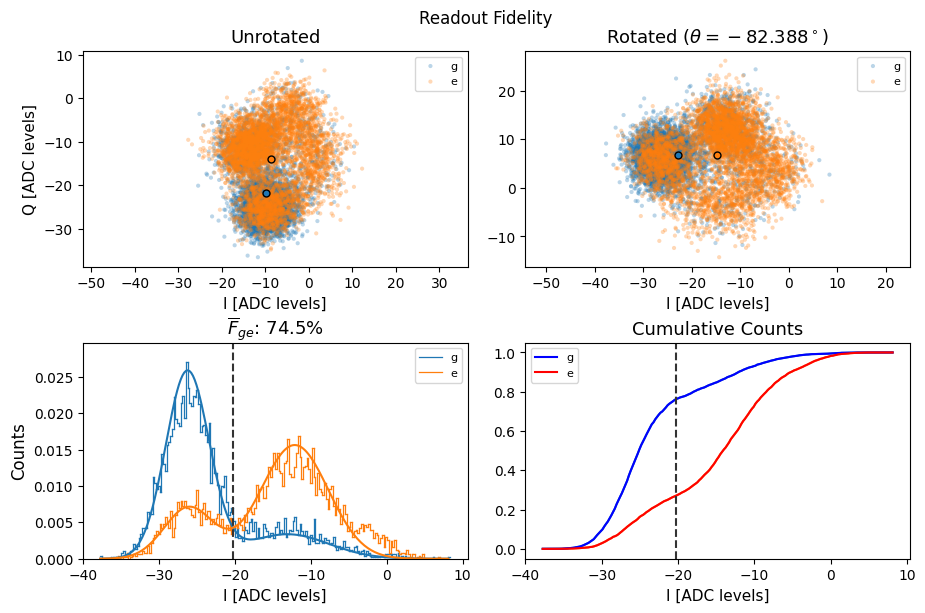

fidelity:[0.7454] 
thressholds:[-20.21005026801767] 
theta:-82.38782249129157, 
n_tot_g[0.0004 0.     0.     0.     0.     0.     0.0002 0.     0.0002 0.
 0.     0.0002 0.0008 0.001  0.0006 0.0004 0.0006 0.001  0.0012 0.002
 0.0014 0.0018 0.0028 0.0034 0.0042 0.0042 0.0042 0.0064 0.0062 0.0062
 0.0112 0.0104 0.0096 0.01   0.0092 0.0144 0.013  0.012  0.0156 0.016
 0.0168 0.0178 0.0222 0.0192 0.0186 0.0182 0.0214 0.0224 0.0194 0.027
 0.0234 0.0214 0.021  0.0224 0.0222 0.0232 0.0212 0.0174 0.0182 0.0184
 0.017  0.016  0.0186 0.0104 0.0152 0.0118 0.0118 0.0102 0.0062 0.01
 0.0098 0.0114 0.0078 0.006  0.0064 0.007  0.0052 0.003  0.0042 0.0028
 0.0028 0.0024 0.0044 0.004  0.0036 0.005  0.0054 0.0038 0.005  0.0028
 0.0042 0.0028 0.0028 0.0048 0.0042 0.0038 0.003  0.0036 0.0036 0.0028
 0.0044 0.005  0.0034 0.004  0.0036 0.0056 0.003  0.0034 0.004  0.0038
 0.0052 0.0058 0.004  0.0032 0.0048 0.0038 0.0032 0.0038 0.0028 0.002
 0.0032 0.0024 0.0054 0.0022 0.0022 0.0034 0.0024 0.0022 0.0028 0.0026


In [7]:

histt(data, fid_avg=True, fit=True)

# old

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from double_gauss_fit import cal_hist

def histtests(data, plot=True, span=None, verbose=True, title=None, fid_avg=False, fit=False, b_print=False, b_plot=False):
    """
    span: histogram limit is the mean +/- span
    fid_avg: if True, calculate fidelity F by the average mis-categorized e/g; otherwise count
        total number of miscategorized over total counts (gives F^2)
    """
    testtitle = title
    Ig = data[0]
    Qg = data[1]
    Ie = data[2]
    Qe = data[3]

    plot_f = False
    if plot_f:  # 'If' in data.keys():
        plot_f = True
        If = data[4]
        Qf = data[5]

    numbins = 200

    xg, yg = np.median(Ig), np.median(Qg)
    xe, ye = np.median(Ie), np.median(Qe)
    if plot_f:
        xf, yf = np.median(If), np.median(Qf)

    if verbose:
        print('Unrotated:')
        print(f'Ig {xg} +/- {np.std(Ig)} \t Qg {yg} +/- {np.std(Qg)} \t Amp g {np.abs(xg+1j*yg)} +/- {np.std(np.abs(Ig + 1j*Qg))}')
        print(f'Ie {xe} +/- {np.std(Ie)} \t Qe {ye} +/- {np.std(Qe)} \t Amp e {np.abs(xe+1j*ye)} +/- {np.std(np.abs(Ig + 1j*Qe))}')
        if plot_f:
            print(
                f'If {xf} +/- {np.std(If)} \t Qf {yf} +/- {np.std(Qf)} \t Amp f {np.abs(xf+1j*yf)}')

    if plot:
        if b_plot:
            fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
        else:
            fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
        if title is not None:
            plt.suptitle(title)
        fig.tight_layout()

        axs[0, 0].scatter(Ig, Qg, label='g', color='b',
                          marker='.', edgecolor='None', alpha=0.2)
        axs[0, 0].scatter(Ie, Qe, label='e', color='r',
                          marker='.', edgecolor='None', alpha=0.2)
        if plot_f:
            axs[0, 0].scatter(If, Qf, label='f', color='g',
                              marker='.', edgecolor='None', alpha=0.2)
        axs[0, 0].plot([xg], [yg], color='k', linestyle=':',
                       marker='o', markerfacecolor='b', markersize=5)
        axs[0, 0].plot([xe], [ye], color='k', linestyle=':',
                       marker='o', markerfacecolor='r', markersize=5)
        if plot_f:
            axs[0, 0].plot([xf], [yf], color='k', linestyle=':',
                           marker='o', markerfacecolor='g', markersize=5)

        # axs[0,0].set_xlabel('I [ADC levels]')
        axs[0, 0].set_ylabel('Q [ADC levels]')
        axs[0, 0].legend(loc='upper right')
        axs[0, 0].set_title('Unrotated', fontsize=14)
        axs[0, 0].axis('equal')

    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg), (xe-xg))
    if plot_f:
        theta = -np.arctan2((yf-yg), (xf-xg))

    """
    Adjust rotation angle
    """
    best_theta = theta
    I_tot = np.concatenate((Ie, Ig))
    span = (np.max(I_tot) - np.min(I_tot))/2
    midpoint = (np.max(I_tot) + np.min(I_tot))/2
    xlims = [midpoint-span, midpoint+span]
    ng, binsg = np.histogram(Ig, bins=numbins, range=xlims)
    ne, binse = np.histogram(Ie, bins=numbins, range=xlims)
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) /
                      (0.5*ng.sum() + 0.5*ne.sum())))
    best_fid = np.max(contrast)
    for theta_i in np.linspace(theta-np.pi/12, theta + np.pi/12, 10):
        Ig_new = Ig*np.cos(theta_i) - Qg*np.sin(theta_i)
        Qg_new = Ig*np.sin(theta) + Qg*np.cos(theta)
        Ie_new = Ie*np.cos(theta_i) - Qe*np.sin(theta_i)
        Qe_new = Ie*np.sin(theta) + Qe*np.cos(theta)
        xg, yg = np.median(Ig_new), np.median(Qg_new)
        xe, ye = np.median(Ie_new), np.median(Qe_new)
        I_tot_new = np.concatenate((Ie_new, Ig_new))
        span = (np.max(I_tot_new) - np.min(I_tot_new))/2
        midpoint = (np.max(I_tot_new) + np.min(I_tot_new))/2
        xlims = [midpoint-span, midpoint+span]
        ng, binsg = np.histogram(Ig_new, bins=numbins, range=xlims)
        ne, binse = np.histogram(Ie_new, bins=numbins, range=xlims)
        contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) /
                          (0.5*ng.sum() + 0.5*ne.sum())))
        fid = np.max(contrast)
        if fid > best_fid:
            best_theta = theta_i
            best_fid = fid
    theta = best_theta

    """Rotate the IQ data"""
    Ig_new = Ig*np.cos(theta) - Qg*np.sin(theta)
    Qg_new = Ig*np.sin(theta) + Qg*np.cos(theta)

    Ie_new = Ie*np.cos(theta) - Qe*np.sin(theta)
    Qe_new = Ie*np.sin(theta) + Qe*np.cos(theta)

    if plot_f:
        If_new = If*np.cos(theta) - Qf*np.sin(theta)
        Qf_new = If*np.sin(theta) + Qf*np.cos(theta)

    """New means of each blob"""
    xg, yg = np.median(Ig_new), np.median(Qg_new)
    xe, ye = np.median(Ie_new), np.median(Qe_new)
    if plot_f:
        xf, yf = np.median(If_new), np.median(Qf_new)
    if verbose:
        print('Rotated:')
        print(f'Ig {xg} +/- {np.std(Ig)} \t Qg {yg} +/- {np.std(Qg)} \t Amp g {np.abs(xg+1j*yg)} +/- {np.std(np.abs(Ig + 1j*Qg))}')
        print(f'Ie {xe} +/- {np.std(Ie)} \t Qe {ye} +/- {np.std(Qe)} \t Amp e {np.abs(xe+1j*ye)} +/- {np.std(np.abs(Ig + 1j*Qe))}')
        if plot_f:
            print(
                f'If {xf} +/- {np.std(If)} \t Qf {yf} +/- {np.std(Qf)} \t Amp f {np.abs(xf+1j*yf)}')

    if span is None:
        span = (np.max(np.concatenate((Ie_new, Ig_new))) -
                np.min(np.concatenate((Ie_new, Ig_new))))/2
    xlims = [(xg+xe)/2-span, (xg+xe)/2+span]


    if plot:
        axs[0, 1].scatter(Ig_new, Qg_new, label='g', color='b',
                          marker='.', edgecolor='None', alpha=0.3)
        axs[0, 1].scatter(Ie_new, Qe_new, label='e', color='r',
                          marker='.', edgecolor='None', alpha=0.3)
        if plot_f:
            axs[0, 1].scatter(If_new, Qf_new, label='f', color='g',
                              marker='.', edgecolor='None', alpha=0.3)
        axs[0, 1].plot([xg], [yg], color='k', linestyle=':',
                       marker='o', markerfacecolor='b', markersize=5)
        axs[0, 1].plot([xe], [ye], color='k', linestyle=':',
                       marker='o', markerfacecolor='r', markersize=5)
        if plot_f:
            axs[0, 1].plot([xf], [yf], color='k', linestyle=':',
                           marker='o', markerfacecolor='g', markersize=5)

        axs[0, 1].set_xlabel('I [ADC levels]')
        axs[0, 1].legend(loc='upper right')
        axs[0, 1].set_title('Rotated', fontsize=14)
        axs[0, 1].axis('equal')

        """X and Y ranges for histogram"""

        ng, binsg, pg = axs[1, 0].hist(
            Ig_new, bins=numbins, range=xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[1, 0].hist(
            Ie_new, bins=numbins, range=xlims, color='r', label='e', alpha=0.5)
        if plot_f:
            nf, binsf, pf = axs[1, 0].hist(
                If_new, bins=numbins, range=xlims, color='g', label='f', alpha=0.5)
        axs[1, 0].set_ylabel('Counts', fontsize=14)
        axs[1, 0].set_xlabel('I [ADC levels]', fontsize=14)
        axs[1, 0].legend(loc='upper right')

    else:
        ng, binsg = np.histogram(Ig_new, bins=numbins, range=xlims)
        ne, binse = np.histogram(Ie_new, bins=numbins, range=xlims)
        if plot_f:
            nf, binsf = np.histogram(If_new, bins=numbins, range=xlims)

    """fitting the shot gaussian"""

    n_tot_g = [0] * numbins
    n_tot_e = [0] * numbins
    iqshots=[(Ig, Qg), (Ie, Qe)]
    for check_i, data_check in enumerate(iqshots):
        if check_i in [0]:
            n_tot_g += ng
            binsg = binsg
        elif check_i in [1]:
            n_tot_e += ne
            binse = binse

    if fit:
        xmax_g = binsg[np.argmax(n_tot_g)]
        xmax_e = binse[np.argmax(n_tot_e)]

        # a bit stupid but we need to know what the g and e states are to fit the gaussians, and
        # that requires having already looped through all the states once
        popt_lst=[]
        for check_i, data_check in enumerate(iqshots):

            I, Q = data_check

            xavg, yavg = np.average(I), np.average(Q)

            I_new = I * np.cos(theta) - Q * np.sin(theta)
            Q_new = I * np.sin(theta) + Q * np.cos(theta)

            n, bins = np.histogram(I_new , bins=numbins, range=xlims)

            idx_g = np.argmin(np.abs(bins[:-1] - xmax_g))
            idx_e = np.argmin(np.abs(bins[:-1] - xmax_e))
            ymax_g = n[idx_g]
            ymax_e = n[idx_e]
            fitparams = [ymax_g, xmax_g, 10, ymax_e, xmax_e, 10]

            popt, pcov = fitter.fit_doublegauss(
                xdata=bins[:-1], ydata=n, fitparams=fitparams)
            popt_lst.append(popt)
            if plot:
                y = fitter.double_gaussian(bins[:-1], *popt)
                y_norm = y 

                axs[1, 0].plot(
                    bins[:-1],
                    y_norm,
                    "-"
                    )
                

                
    """Compute the fidelity using overlap of the histograms"""
    fids = []
    thresholds = []
    # this method calculates fidelity as 1-2(Neg + Nge)/N
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) /
                      (0.5*ng.sum() + 0.5*ne.sum())))
    tind = contrast.argmax()
    thresholds.append(binsg[tind])

    if not fid_avg:
        fids.append(contrast[tind])
    else:
        # this method calculates fidelity as (Ngg+Nee)/N = Ngg/N + Nee/N=(0.5N-Nge)/N + (0.5N-Neg)/N = 1-(Nge+Neg)/N
        fids.append(0.5*(1-ng[tind:].sum()/ng.sum() +
                    1-ne[:tind].sum()/ne.sum()))
    if verbose:
        print(f'g correctly categorized: {100*(1-ng[tind:].sum()/ng.sum())}%')
        print(f'e correctly categorized: {100*(1-ne[:tind].sum()/ne.sum())}%')

    if plot_f:
        contrast = np.abs(((np.cumsum(ng) - np.cumsum(nf)) /
                          (0.5*ng.sum() + 0.5*nf.sum())))
        tind = contrast.argmax()
        thresholds.append(binsg[tind])
        if not fid_avg:
            fids.append(contrast[tind])
        else:
            fids.append(
                0.5*(1-ng[tind:].sum()/ng.sum() + 1-nf[:tind].sum()/nf.sum()))

        contrast = np.abs(((np.cumsum(ne) - np.cumsum(nf)) /
                          (0.5*ne.sum() + 0.5*nf.sum())))
        tind = contrast.argmax()
        thresholds.append(binsg[tind])
        if not fid_avg:
            fids.append(contrast[tind])
        else:
            fids.append(
                0.5*(1-ne[tind:].sum()/ne.sum() + 1-nf[:tind].sum()/nf.sum()))

    if plot:
        title = '$\overline{F}_{ge}$' if fid_avg else '$F_{ge}$'
        axs[1, 0].set_title(
            f'Histogram ({title}: {100*fids[0]:.3}%)', fontsize=14)
        axs[1, 0].axvline(thresholds[0], color='0.2', linestyle='--')
        if plot_f:
            axs[1, 0].axvline(thresholds[1], color='0.2', linestyle='--')
            axs[1, 0].axvline(thresholds[2], color='0.2', linestyle='--')

        axs[1, 1].set_title('Cumulative Counts', fontsize=14)
        axs[1, 1].plot(binsg[:-1], np.cumsum(ng), 'b', label='g')
        axs[1, 1].plot(binse[:-1], np.cumsum(ne), 'r', label='e')
        axs[1, 1].axvline(thresholds[0], color='0.2', linestyle='--')
        if plot_f:
            # axs[1, 1].plot(binsf[:-1], np.cumsum(nf), 'g', label='f')
            axs[1, 1].axvline(thresholds[1], color='0.2', linestyle='--')
            axs[1, 1].axvline(thresholds[2], color='0.2', linestyle='--')
        axs[1, 1].legend()
        axs[1, 1].set_xlabel('I [ADC levels]', fontsize=14)

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        plt.tight_layout()


    gg = 100*(1-ng[tind:].sum()/ng.sum())
    ge = 100*(ng[tind:].sum()/ng.sum())
    eg = 100*(1-ne[tind:].sum()/ng.sum())
    ee = 100*(ne[tind:].sum()/ng.sum())

    if b_print:
        print(
            f"""
        Fidelity Matrix:
        -----------------
        | {gg:.3f}% | {ge:.3f}% |
        ----------------
        | {eg:.3f}% | {ee:.3f}% |
        -----------------
        IQ plane rotated by: {180 / np.pi * theta:.1f}{chr(176)}
        Threshold: {thresholds[0]:.3e}
        Fidelity: {100*fids[0]:.3f}%
        """
        )

    if b_plot:
        axs[0, 2].imshow(np.array([[gg, ge], [eg, ee]]))
        axs[0, 2].set_xticks([0, 1])
        axs[0, 2].set_yticks([0, 1])
        axs[0, 2].set_xticklabels(labels=["|g>", "|e>"])
        axs[0, 2].set_yticklabels(labels=["|g>", "|e>"])
        axs[0, 2].set_ylabel("Prepared", fontsize=14)
        axs[0, 2].set_xlabel("Measured", fontsize=14)
        axs[0, 2].text(0, 0, f"{gg:.1f}%", ha="center", va="center", color="k")
        axs[0, 2].text(1, 0, f"{ge:.1f}%", ha="center", va="center", color="w")
        axs[0, 2].text(0, 1, f"{eg:.1f}%", ha="center", va="center", color="w")
        axs[0, 2].text(1, 1, f"{ee:.1f}%", ha="center", va="center", color="k")
        axs[0, 2].set_title("Fidelities", fontsize=14)

        # lower right text setting
        text_kwargs = dict(ha='center', va='center', fontsize=12)
        axs[1, 2].text(0.45, 0.5, f"""
        Fidelity Matrix:
        -----------------
        | {gg:.3f}% | {ge:.3f}% |
        ----------------
        | {eg:.3f}% | {ee:.3f}% |
        -----------------
        IQ plane rotated by: {180 / np.pi * theta:.1f}{chr(176)}
        Threshold: {thresholds[0]:.3e}
        Fidelity: {100*fids[0]:.3f}%
        """, **text_kwargs)
        axs[1, 2].spines['right'].set_color('none')
        axs[1, 2].spines['left'].set_color('none')
        axs[1, 2].spines['bottom'].set_color('none')
        axs[1, 2].spines['top'].set_color('none')
        axs[1, 2].set_xticks([])
        axs[1, 2].set_yticks([])

    plt.subplots_adjust(hspace=0.25, wspace=0.15)
    plt.tight_layout()


    plt.show()
    return fids, thresholds, theta*180/np.pi  # fids: ge, gf, ef


Unrotated:
Ig -9.910077519379845 +/- 4.303173072874779 	 Qg -23.801550387596897 +/- 6.969469345442492 	 Amp g 25.782231037934476 +/- 5.882512901454693
Ie -9.686046511627907 +/- 6.306720121908508 	 Qe -12.555813953488371 +/- 8.019850428341863 	 Amp e 15.857741360610989 +/- 6.695581636698151
Rotated:
Ig -24.725571872360064 +/- 4.303173072874779 	 Qg 7.324447229837902 +/- 6.969469345442492 	 Amp g 25.787621674709037 +/- 5.882512901454693
Ie -13.61080472621114 +/- 6.306720121908508 	 Qe 7.963878243784799 +/- 8.019850428341863 	 Amp e 15.769507347310515 +/- 6.695581636698151
g correctly categorized: 75.7703081232493%
e correctly categorized: 73.09695512820514%

        Fidelity Matrix:
        -----------------
        | 75.770% | 24.230% |
        ----------------
        | 26.991% | 73.009% |
        -----------------
        IQ plane rotated by: -83.9°
        Threshold: -2.010e+01
        Fidelity: 49.169%
        


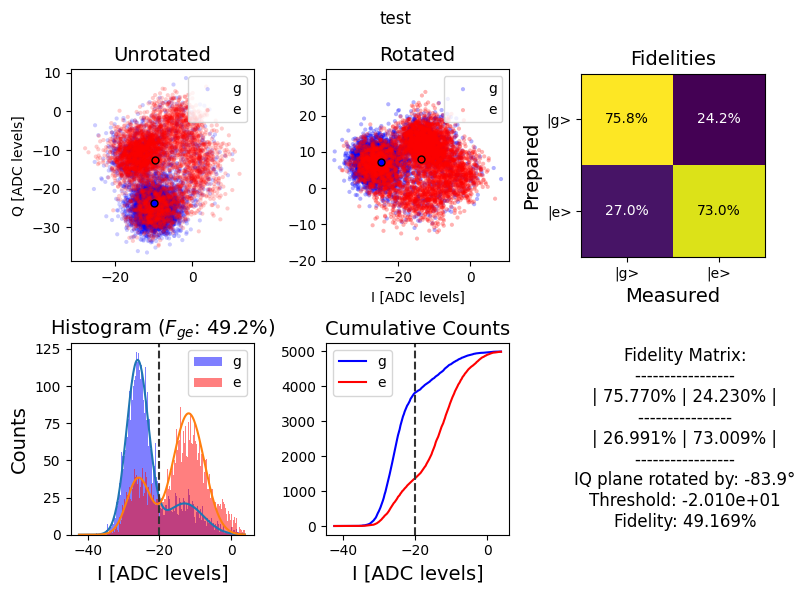

In [ ]:
dataset =[Ig, Qg, Ie, Qe]
_, _, _= histtests(data=dataset, b_plot=True, b_print=True, fit=True, title='test')


In [53]:
popt[1]

array([101.65      ,  -7.79044828,   6.97910545, 131.1       ,
        10.52691937,   7.84163252])

In [42]:
import sys
import os
import numpy as np
# os.chdir(r'D:\Jay PhD\Code\data_fitting\data')
sys.path.append(r'C:\Program Files\Keysight\Labber\Script')
import Labber
import matplotlib.pyplot as plt
np.bool = bool
np.float = np.float64

In [47]:
from pathlib import Path, WindowsPath
gain=5000
shot = f"\q2 single shot with twpa, gain={gain}.hdf5"
Path('D:\Jay PhD\Code\data_fitting\data\singleshot' + shot)

WindowsPath('D:/Jay PhD/Code/data_fitting/data/singleshot/q2 single shot with twpa, gain=5000.hdf5')

Unrotated:
Ig -0.9948320413436693 +/- 13.96316886656862 	 Qg -0.45478036175710596 +/- 14.253887940337046 	 Amp g 1.0938537232756198 +/- 9.156675585363828
Ie -2.6821705426356592 +/- 13.99542615615915 	 Qe 2.3462532299741605 +/- 14.192969701674253 	 Amp e 3.563557637943667 +/- 9.362036092834929
Rotated:
Ig 0.5833993930120167 +/- 13.96316886656862 	 Qg 1.2568270857589678 +/- 14.253887940337046 	 Amp g 1.3856295230920022 +/- 9.156675585363828
Ie 3.7394117122375965 +/- 13.99542615615915 	 Qe -0.059973481665549055 +/- 14.192969701674253 	 Amp e 3.7398926150523093 +/- 9.362036092834929
Attempted to init fitparam 1 to 2.1614055526248066, which is out of bounds -52.42835971128681 to 1.8884567263052503. Instead init to -25.26995149249078
Attempted to init fitparam 4 to -1.1139803632098904, which is out of bounds 1.8884567263052503 to 56.20527316389731. Instead init to 29.04686494510128
Attempted to init fitparam 1 to 2.1614055526248066, which is out of bounds -52.42835971128681 to 1.888456726305

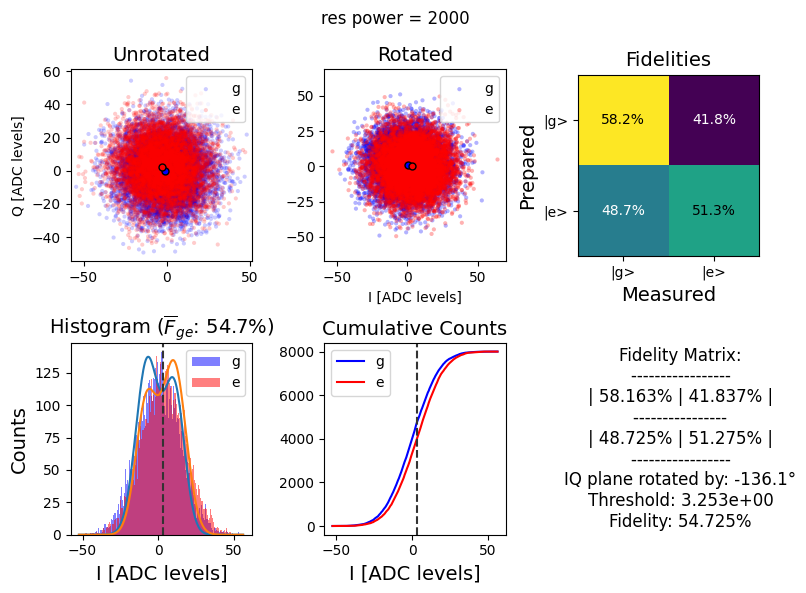

Unrotated:
Ig -1.34625322997416 +/- 14.285114409339627 	 Qg -0.82687338501292 +/- 14.31037843301099 	 Amp g 1.5799105525499169 +/- 9.389003178974692
Ie -3.3669250645994833 +/- 14.134007675649947 	 Qe 2.8940568475452197 +/- 14.241589121539585 	 Amp e 4.439791597299541 +/- 9.454937443182681
Rotated:
Ig -0.37190907756545233 +/- 14.285114409339627 	 Qg 1.4915687574944956 +/- 14.31037843301099 	 Amp g 1.537235739992165 +/- 9.389003178974692
Ie 4.1723593287800895 +/- 14.134007675649947 	 Qe 1.717240178866806 +/- 14.241589121539585 	 Amp e 4.511928213122715 +/- 9.454937443182681
Attempted to init fitparam 4 to -0.30212330559515266, which is out of bounds 1.624931571707009 to 56.40834879786843. Instead init to 29.01664018478772
Attempted to init fitparam 4 to -0.30212330559515266, which is out of bounds 1.624931571707009 to 56.40834879786843. Instead init to 29.01664018478772
g correctly categorized: 48.456057007125885%
e correctly categorized: 63.85000000000001%

        Fidelity Matrix:
    

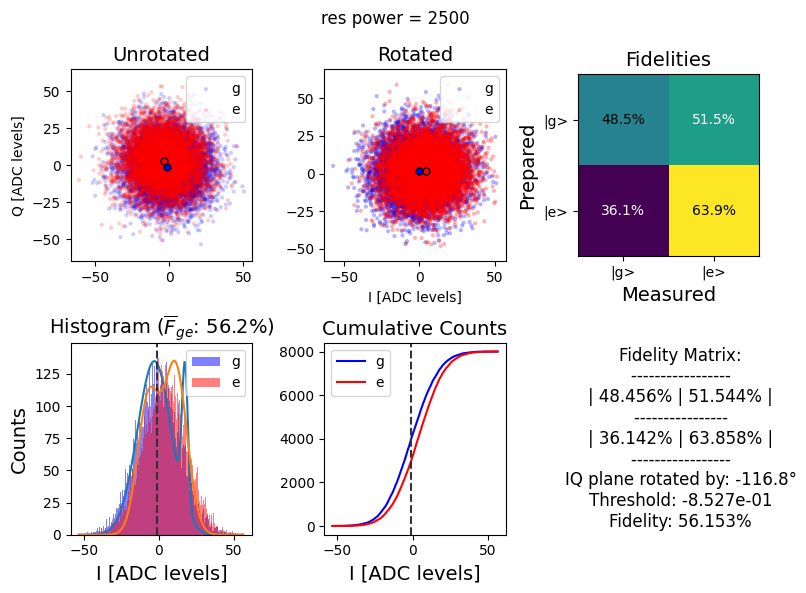

Unrotated:
Ig -1.7260981912144704 +/- 14.241603417694684 	 Qg -0.5090439276485789 +/- 14.392238226546034 	 Amp g 1.79959458934221 +/- 9.465134479371212
Ie -3.9702842377260983 +/- 14.405412174490282 	 Qe 3.4573643410852712 +/- 14.776399147977198 	 Amp e 5.264648622210631 +/- 9.655497076215278
Rotated:
Ig 0.5794242526759084 +/- 14.241603417694684 	 Qg 2.0031865914866263 +/- 14.392238226546034 	 Amp g 2.0853030918551965 +/- 9.465134479371212
Ie 5.198918656960343 +/- 14.405412174490282 	 Qe 1.4724802732648905 +/- 14.776399147977198 	 Amp e 5.403420523783485 +/- 9.655497076215278
g correctly categorized: 60.0%
e correctly categorized: 53.24415551943993%

        Fidelity Matrix:
        -----------------
        | 60.000% | 40.000% |
        ----------------
        | 46.762% | 53.238% |
        -----------------
        IQ plane rotated by: -124.5°
        Threshold: 4.015e+00
        Fidelity: 56.622%
        


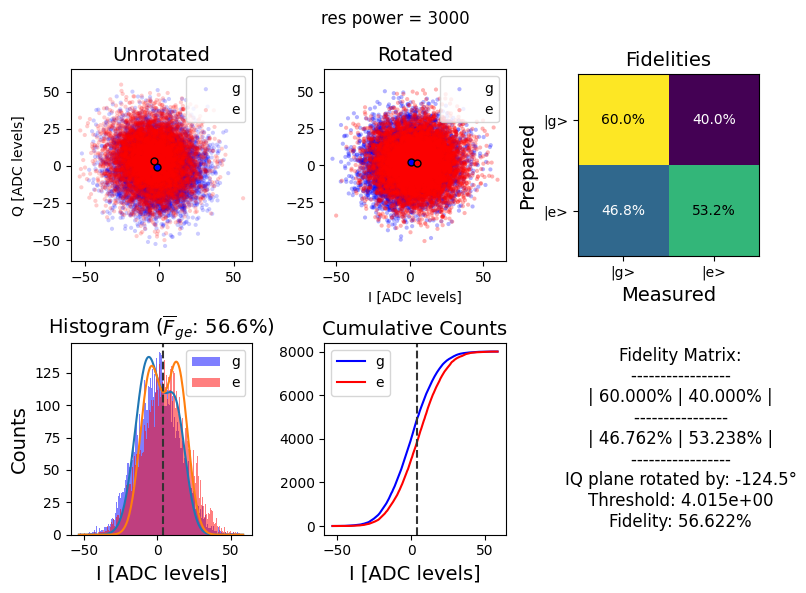

Unrotated:
Ig -1.727390180878553 +/- 14.451877808063823 	 Qg -0.79328165374677 +/- 14.584407555134666 	 Amp g 1.9008347164250894 +/- 9.588652369893758
Ie -4.832041343669251 +/- 14.403930770131478 	 Qe 4.412144702842378 +/- 14.593663032073598 	 Amp e 6.543366444403752 +/- 9.74542035615836
Rotated:
Ig -0.06055030519967053 +/- 14.451877808063823 	 Qg 1.8553435694384461 +/- 14.584407555134666 	 Amp g 1.8563313551508975 +/- 9.588652369893758
Ie 5.942208187734755 +/- 14.403930770131478 	 Qe 3.161553556773078 +/- 14.593663032073598 	 Amp e 6.730918142328464 +/- 9.74542035615836
Attempted to init fitparam 4 to 0.6450170431307214, which is out of bounds 2.653852454000436 to 59.762173420153815. Instead init to 31.208012937077125
Attempted to init fitparam 4 to 0.6450170431307214, which is out of bounds 2.653852454000436 to 59.762173420153815. Instead init to 31.208012937077125
g correctly categorized: 44.25%
e correctly categorized: 71.76794198549638%

        Fidelity Matrix:
        ----------

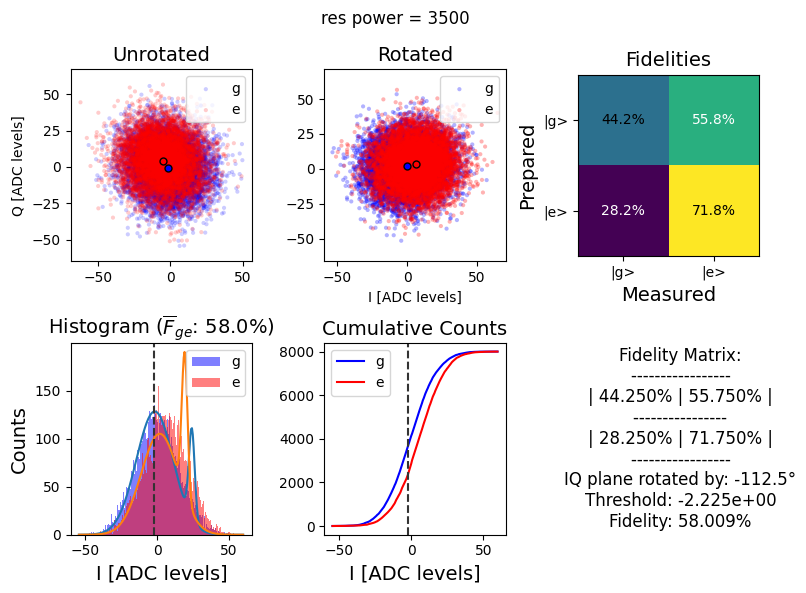

Unrotated:
Ig -2.0736434108527133 +/- 14.882400336333857 	 Qg -1.058139534883721 +/- 14.93109820798274 	 Amp g 2.3280155219965377 +/- 10.00552311584053
Ie -5.3785529715762275 +/- 14.584197465112997 	 Qe 5.134366925064599 +/- 15.087711572717096 	 Amp e 7.43576195081908 +/- 10.111582373334173
Rotated:
Ig -0.12228212822260343 +/- 14.882400336333857 	 Qg 2.2225436003059045 +/- 14.93109820798274 	 Amp g 2.2259049786869567 +/- 10.00552311584053
Ie 7.040981673715709 +/- 14.584197465112997 	 Qe 2.36904714953904 +/- 15.087711572717096 	 Amp e 7.428849663732571 +/- 10.111582373334173
g correctly categorized: 51.10638829853732%
e correctly categorized: 66.10000000000001%

        Fidelity Matrix:
        -----------------
        | 51.106% | 48.894% |
        ----------------
        | 33.892% | 66.108% |
        -----------------
        IQ plane rotated by: -119.8°
        Threshold: 2.790e-01
        Fidelity: 58.603%
        


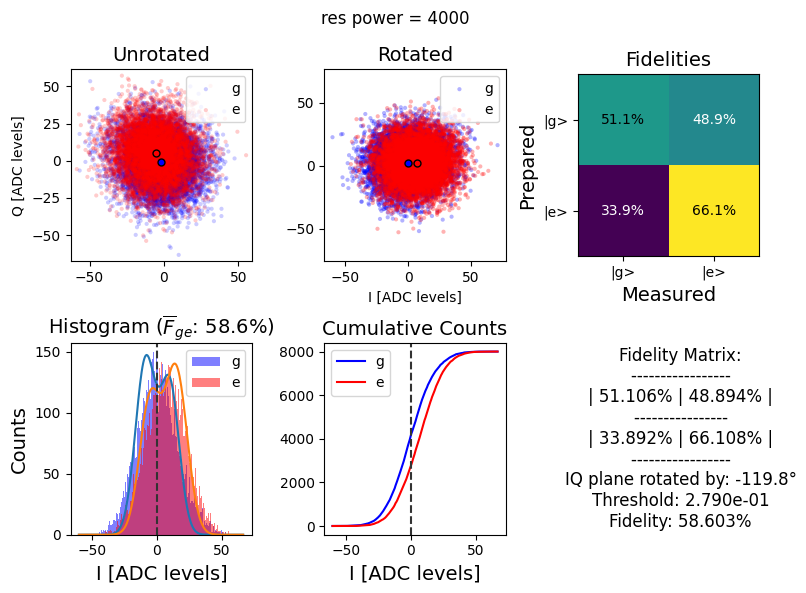

Unrotated:
Ig -2.2829457364341086 +/- 14.5094020113851 	 Qg -1.073643410852713 +/- 15.120428504363158 	 Amp g 2.5228062567645027 +/- 9.931428070879777
Ie -6.204134366925064 +/- 14.84473889553203 	 Qe 5.630490956072352 +/- 15.176842058409145 	 Amp e 8.378168752733094 +/- 10.109526150177105
Rotated:
Ig -0.16278873180950737 +/- 14.5094020113851 	 Qg 2.604469363975457 +/- 15.120428504363158 	 Amp g 2.6095518464078977 +/- 9.931428070879777
Ie 8.08985158920523 +/- 14.84473889553203 	 Qe 2.757912636794659 +/- 15.176842058409145 	 Amp e 8.547033453050132 +/- 10.109526150177105
g correctly categorized: 60.3375%
e correctly categorized: 60.19502437804726%

        Fidelity Matrix:
        -----------------
        | 60.337% | 39.663% |
        ----------------
        | 39.812% | 60.188% |
        -----------------
        IQ plane rotated by: -118.7°
        Threshold: 3.964e+00
        Fidelity: 60.266%
        


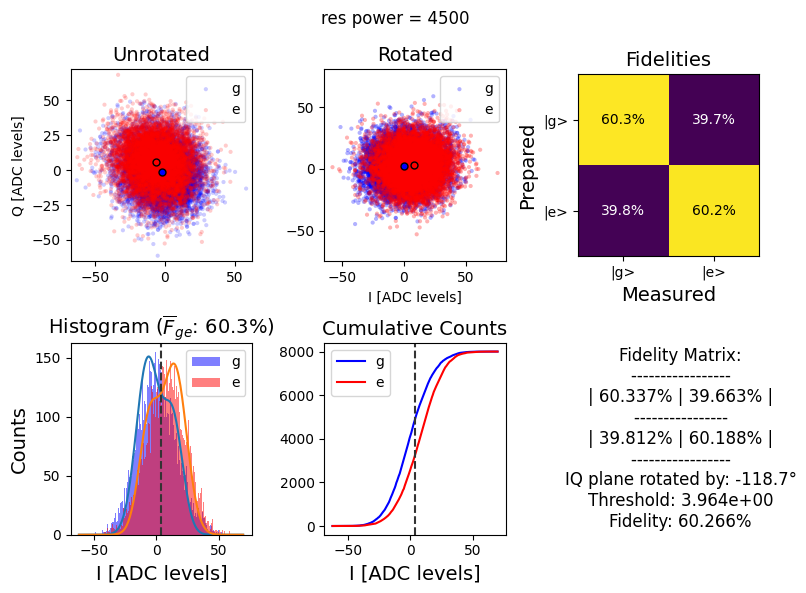

Unrotated:
Ig -2.4728682170542635 +/- 14.919034033072116 	 Qg -0.6795865633074936 +/- 15.32302306036314 	 Amp g 2.5645496906757765 +/- 10.233385621090786
Ie -6.506459948320414 +/- 15.105572947131327 	 Qe 6.220930232558139 +/- 15.434393062539963 	 Amp e 9.00188835841978 +/- 10.387498649024463
Rotated:
Ig 0.2570657878824657 +/- 14.919034033072116 	 Qg 2.783805387918516 +/- 15.32302306036314 	 Amp g 2.795649344446437 +/- 10.233385621090786
Ie 8.492794926458515 +/- 15.105572947131327 	 Qe 3.616495590118296 +/- 15.434393062539963 	 Amp e 9.230742441224573 +/- 10.387498649024463
g correctly categorized: 58.75734466808351%
e correctly categorized: 61.50768846105763%

        Fidelity Matrix:
        -----------------
        | 58.757% | 41.243% |
        ----------------
        | 38.492% | 61.508% |
        -----------------
        IQ plane rotated by: -115.3°
        Threshold: 3.733e+00
        Fidelity: 60.133%
        


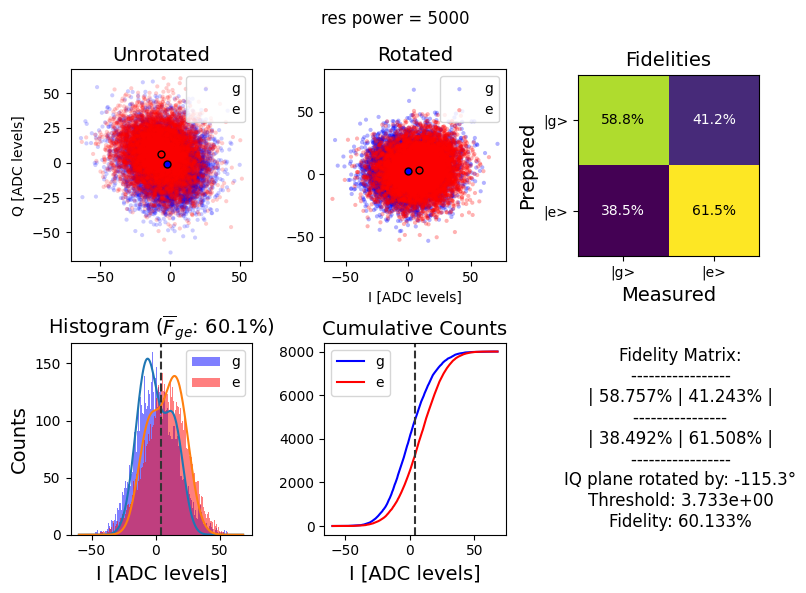

Unrotated:
Ig -2.7945736434108523 +/- 15.547400474341622 	 Qg -0.9961240310077519 +/- 15.801521299622376 	 Amp g 2.9668004539567097 +/- 10.643047370648624
Ie -8.686046511627907 +/- 15.811132877359903 	 Qe 7.6072351421188635 +/- 15.900437838341627 	 Amp e 11.54631675079337 +/- 10.974676484948825
Rotated:
Ig 0.49781598433374896 +/- 15.547400474341622 	 Qg 2.7586148948446114 +/- 15.801521299622376 	 Amp g 2.8031726476114036 +/- 10.643047370648624
Ie 11.734031818004375 +/- 15.811132877359903 	 Qe 2.189822803265727 +/- 15.900437838341627 	 Amp e 11.936617050724282 +/- 10.974676484948825
g correctly categorized: 59.819977497187146%
e correctly categorized: 65.72893223305827%

        Fidelity Matrix:
        -----------------
        | 59.820% | 40.180% |
        ----------------
        | 34.279% | 65.721% |
        -----------------
        IQ plane rotated by: -129.4°
        Threshold: 4.832e+00
        Fidelity: 62.774%
        


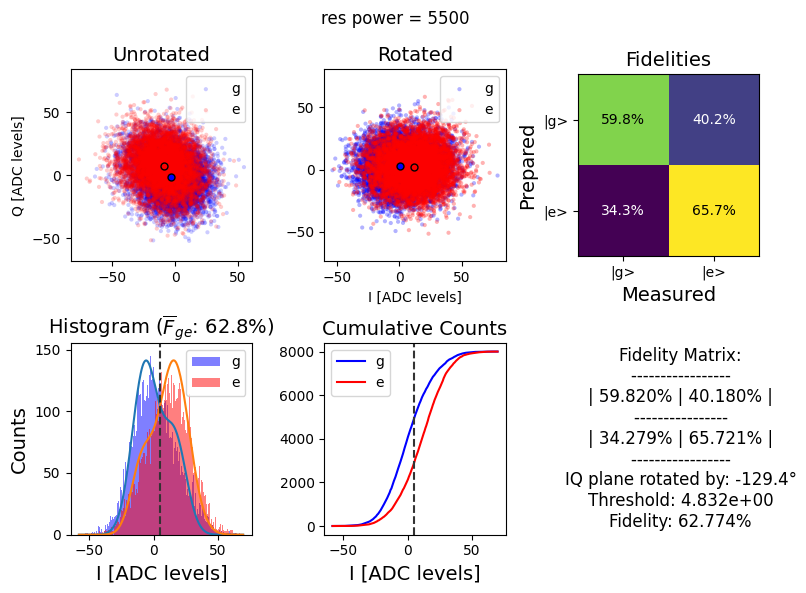

Unrotated:
Ig -3.343669250645995 +/- 16.797892417290427 	 Qg -0.772609819121447 +/- 16.235077573743858 	 Amp g 3.431770678573734 +/- 11.445364709047949
Ie -10.62532299741602 +/- 17.190481411646978 	 Qe 8.321705426356589 +/- 16.027347072725213 	 Amp e 13.496231696383642 +/- 11.55591074328412
Rotated:
Ig 0.9211303686156032 +/- 16.797892417290427 	 Qg 3.2577125845575017 +/- 16.235077573743858 	 Amp g 3.385435339741439 +/- 11.445364709047949
Ie 13.697206741400638 +/- 17.190481411646978 	 Qe 3.5873681799785024 +/- 16.027347072725213 	 Amp e 14.159190759905503 +/- 11.55591074328412
g correctly categorized: 60.515128782195546%
e correctly categorized: 65.64141035258815%

        Fidelity Matrix:
        -----------------
        | 60.515% | 39.485% |
        ----------------
        | 34.359% | 65.641% |
        -----------------
        IQ plane rotated by: -130.4°
        Threshold: 5.833e+00
        Fidelity: 63.078%
        


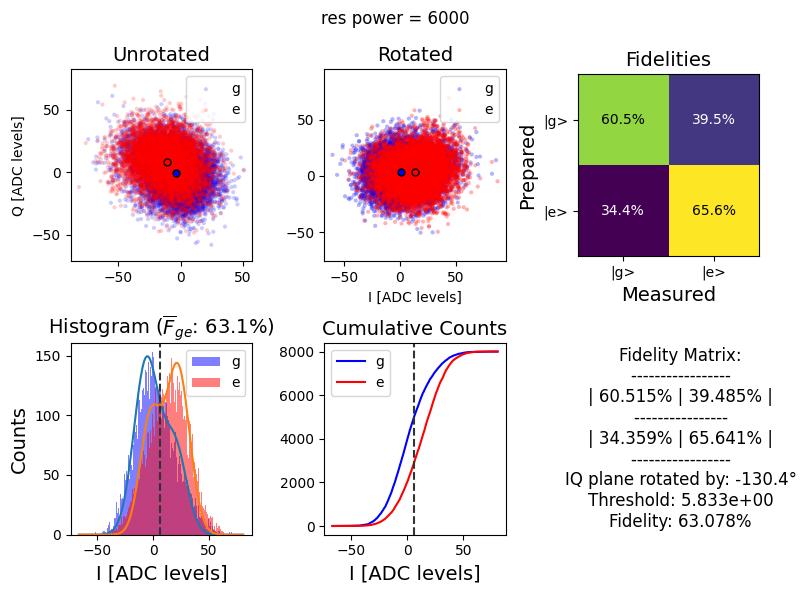

Unrotated:
Ig -3.24031007751938 +/- 16.80490791213608 	 Qg -0.678294573643411 +/- 16.298782175469107 	 Amp g 3.3105426937449014 +/- 11.772416563663246
Ie -11.599483204134366 +/- 17.76594965290141 	 Qe 9.056847545219638 +/- 16.18493088577685 	 Amp e 14.716470298965925 +/- 11.891317877820809
Rotated:
Ig 1.012199324483444 +/- 16.80490791213608 	 Qg 2.8927452221259085 +/- 16.298782175469107 	 Amp g 3.0647222374331102 +/- 11.772416563663246
Ie 15.328505775972413 +/- 17.76594965290141 	 Qe 2.8596245597673775 +/- 16.18493088577685 	 Amp e 15.592964501557887 +/- 11.891317877820809
g correctly categorized: 61.37017127140892%
e correctly categorized: 66.8417104276069%

        Fidelity Matrix:
        -----------------
        | 61.370% | 38.630% |
        ----------------
        | 33.167% | 66.833% |
        -----------------
        IQ plane rotated by: -132.3°
        Threshold: 6.203e+00
        Fidelity: 64.106%
        


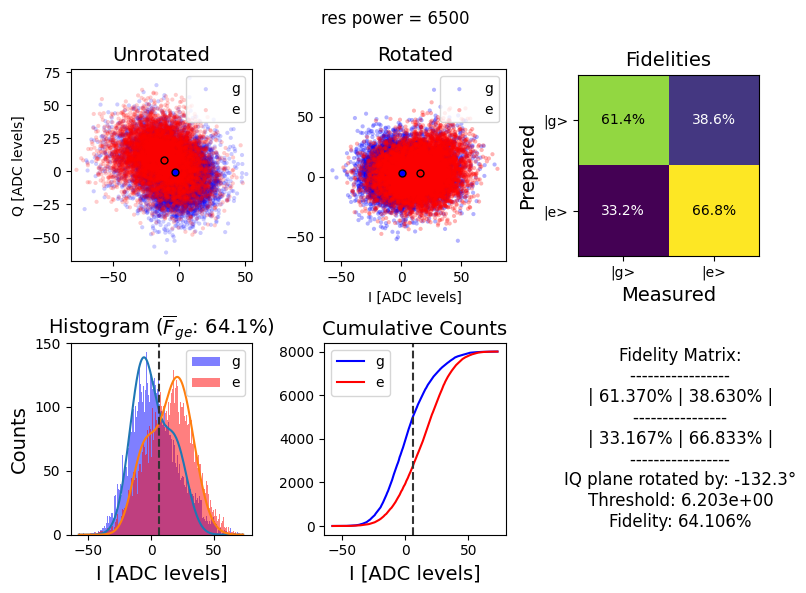

Unrotated:
Ig -3.6395348837209305 +/- 17.787950560052032 	 Qg -0.3449612403100775 +/- 16.383858079761325 	 Amp g 3.6558463352741994 +/- 12.426511953191621
Ie -13.75968992248062 +/- 18.862258368623777 	 Qe 8.891472868217054 +/- 16.350496412793238 	 Amp e 16.38253205487646 +/- 12.523069360904287
Rotated:
Ig 1.5900241791252547 +/- 17.787950560052032 	 Qg 3.4748215122524133 +/- 16.383858079761325 	 Amp g 3.821329798933231 +/- 12.426511953191621
Ie 17.02422744598922 +/- 18.862258368623777 	 Qe 3.8483831105945203 +/- 16.350496412793238 	 Amp e 17.453778178339547 +/- 12.523069360904287
g correctly categorized: 62.43591346755033%
e correctly categorized: 65.97474052769789%

        Fidelity Matrix:
        -----------------
        | 62.436% | 37.564% |
        ----------------
        | 34.025% | 65.975% |
        -----------------
        IQ plane rotated by: -135.9°
        Threshold: 7.960e+00
        Fidelity: 64.205%
        


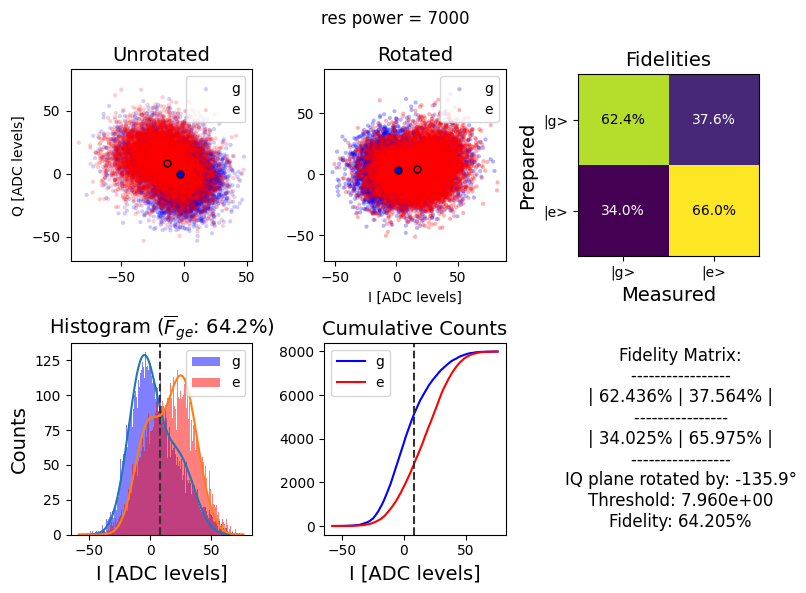

Unrotated:
Ig -3.1136950904392764 +/- 17.367449827900973 	 Qg -0.5503875968992248 +/- 16.61200985583914 	 Amp g 3.161965152092312 +/- 12.447799607143219
Ie -13.430232558139535 +/- 19.48677323611205 	 Qe 10.760981912144704 +/- 16.762660620688266 	 Amp e 17.20958681314623 +/- 12.578347646926797
Rotated:
Ig 0.623019769898217 +/- 17.367449827900973 	 Qg 3.231013180571196 +/- 16.61200985583914 	 Amp g 3.2905318425307515 +/- 12.447799607143219
Ie 17.5333895283329 +/- 19.48677323611205 	 Qe 4.91590660438429 +/- 16.762660620688266 	 Amp e 18.209499885918966 +/- 12.578347646926797
g correctly categorized: 66.35%
e correctly categorized: 65.61250000000001%

        Fidelity Matrix:
        -----------------
        | 66.350% | 33.650% |
        ----------------
        | 34.388% | 65.612% |
        -----------------
        IQ plane rotated by: -127.4°
        Threshold: 9.078e+00
        Fidelity: 65.981%
        


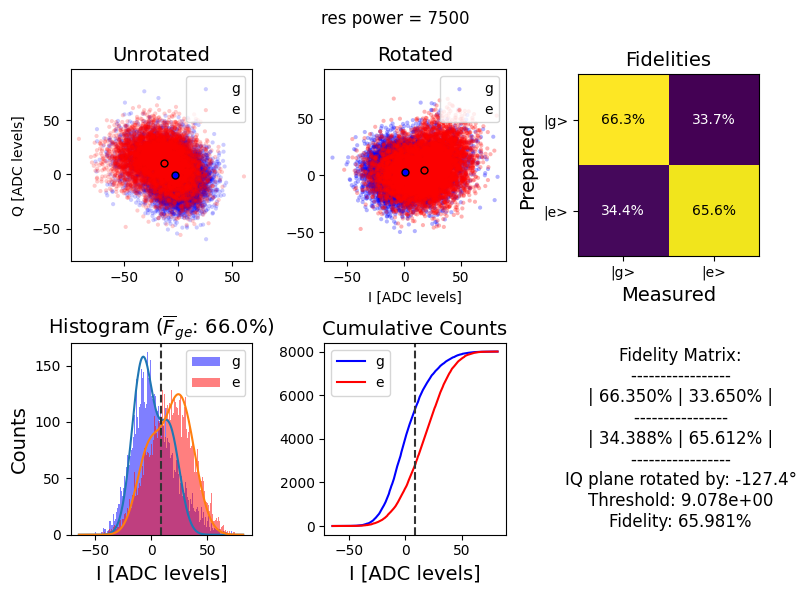

Unrotated:
Ig -4.496124031007752 +/- 18.35346245207207 	 Qg 0.2222222222222222 +/- 17.235115753877967 	 Amp g 4.501612379831784 +/- 13.400588952581096
Ie -13.643410852713178 +/- 19.777904633630197 	 Qe 11.99095607235142 +/- 17.121783877828143 	 Amp e 18.163856617607205 +/- 13.357137435748957
Rotated:
Ig 1.6814997767244977 +/- 18.35346245207207 	 Qg 3.982038603426892 +/- 17.235115753877967 	 Amp g 4.32250771408294 +/- 13.400588952581096
Ie 19.082304278500796 +/- 19.777904633630197 	 Qe 4.737853723782079 +/- 17.121783877828143 	 Amp e 19.661678323206427 +/- 13.357137435748957
g correctly categorized: 63.71139177191447%
e correctly categorized: 66.51232636716307%

        Fidelity Matrix:
        -----------------
        | 63.711% | 36.289% |
        ----------------
        | 33.538% | 66.462% |
        -----------------
        IQ plane rotated by: -126.2°
        Threshold: 9.108e+00
        Fidelity: 65.112%
        


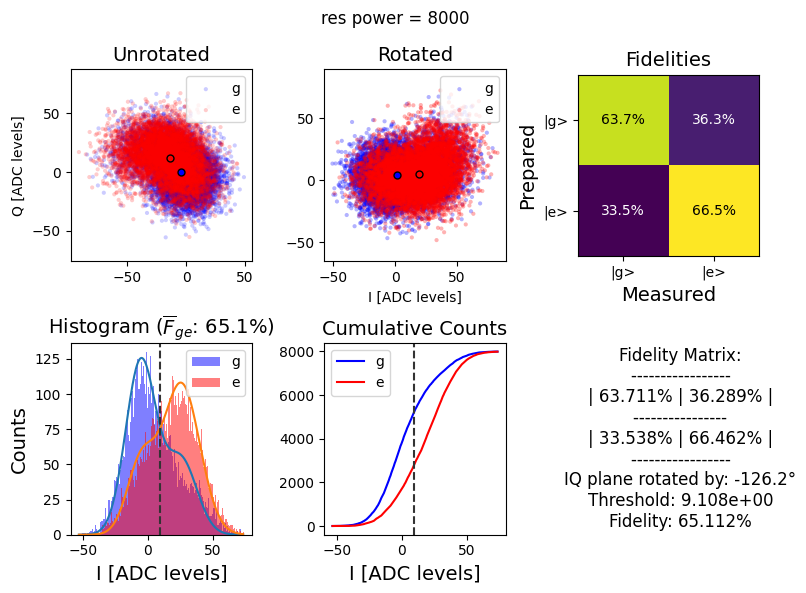

Unrotated:
Ig -3.91343669250646 +/- 17.718253582471185 	 Qg -0.025839793281653745 +/- 16.777101098028186 	 Amp g 3.9135219995769464 +/- 13.300291561682458
Ie -12.457364341085272 +/- 18.647905456404803 	 Qe 11.386304909560724 +/- 16.600115212876766 	 Amp e 16.87702182910331 +/- 13.105795136570187
Rotated:
Ig 1.2192797046470687 +/- 17.718253582471185 	 Qg 3.7752389889484625 +/- 16.777101098028186 	 Amp g 3.9672499822724623 +/- 13.300291561682458
Ie 16.864364916544066 +/- 18.647905456404803 	 Qe 5.999581199761713 +/- 16.600115212876766 	 Amp e 17.89977035078653 +/- 13.105795136570187
g correctly categorized: 65.22880720180044%
e correctly categorized: 65.0%

        Fidelity Matrix:
        -----------------
        | 65.229% | 34.771% |
        ----------------
        | 34.984% | 65.016% |
        -----------------
        IQ plane rotated by: -118.5°
        Threshold: 9.042e+00
        Fidelity: 65.114%
        


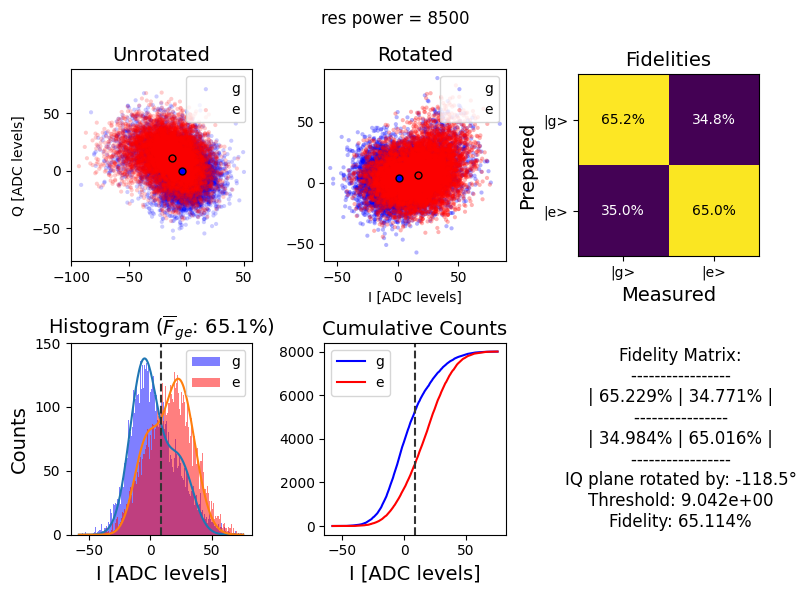

Unrotated:
Ig -3.89922480620155 +/- 18.541344222464208 	 Qg 0.14599483204134367 +/- 17.51417227399192 	 Amp g 3.9019570192763906 +/- 14.01883013858033
Ie -15.041343669250647 +/- 20.415299841289208 	 Qe 13.923772609819121 +/- 17.323064835305427 	 Amp e 20.496669560356768 +/- 13.869285980374848
Rotated:
Ig 1.1695131975209219 +/- 18.541344222464208 	 Qg 3.6589874890994167 +/- 17.51417227399192 	 Amp g 3.841347493336377 +/- 14.01883013858033
Ie 21.432715769674115 +/- 20.415299841289208 	 Qe 6.370262803724602 +/- 17.323064835305427 	 Amp e 22.35937283226331 +/- 13.869285980374848
g correctly categorized: 68.70076278604476%
e correctly categorized: 67.24181045261315%

        Fidelity Matrix:
        -----------------
        | 68.701% | 31.299% |
        ----------------
        | 32.750% | 67.250% |
        -----------------
        IQ plane rotated by: -120.6°
        Threshold: 1.130e+01
        Fidelity: 67.971%
        


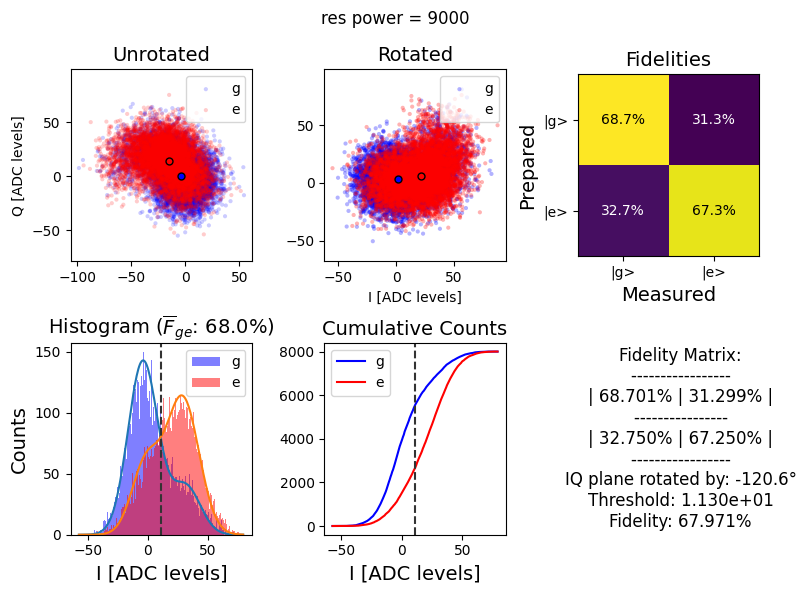

Unrotated:
Ig -4.134366925064599 +/- 18.77378661195516 	 Qg 0.7558139534883721 +/- 17.67215635050931 	 Amp g 4.202885271257809 +/- 14.408750392164293
Ie -15.02454780361757 +/- 20.282322318060327 	 Qe 14.875968992248062 +/- 17.948338603403048 	 Amp e 21.143119215515846 +/- 14.154638207094283
Rotated:
Ig 2.1743303599224584 +/- 18.77378661195516 	 Qg 2.788502596436789 +/- 17.67215635050931 	 Amp g 3.536023083128169 +/- 14.408750392164293
Ie 22.751948599725715 +/- 20.282322318060327 	 Qe 3.20468108470017 +/- 17.948338603403048 	 Amp e 22.976534680825914 +/- 14.154638207094283
g correctly categorized: 68.00450112528131%
e correctly categorized: 67.56756756756756%

        Fidelity Matrix:
        -----------------
        | 68.005% | 31.995% |
        ----------------
        | 32.483% | 67.517% |
        -----------------
        IQ plane rotated by: -129.3°
        Threshold: 1.176e+01
        Fidelity: 67.786%
        


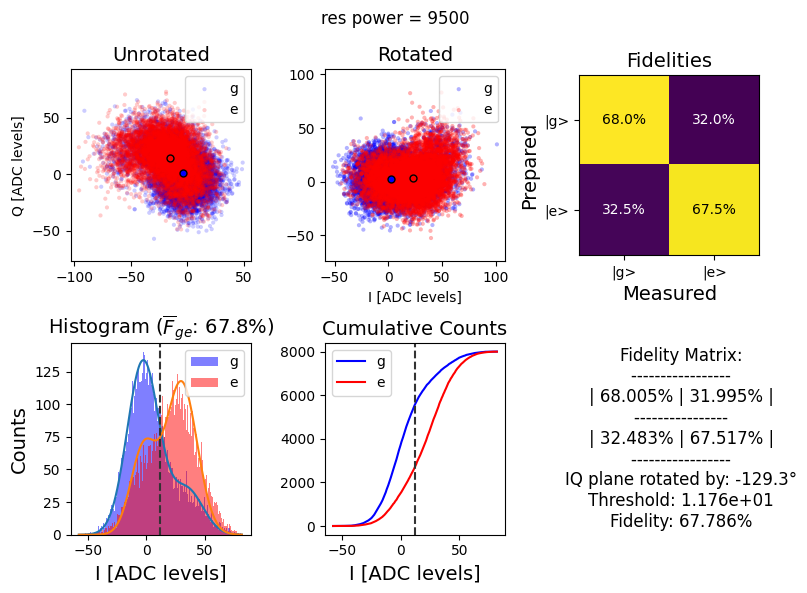

Unrotated:
Ig -4.0490956072351425 +/- 18.90508464166783 	 Qg 1.028423772609819 +/- 17.651309136064732 	 Amp g 4.17765851794997 +/- 14.689267668712658
Ie -16.304909560723516 +/- 20.620422939217995 	 Qe 15.972868217054263 +/- 17.942924711041442 	 Amp e 22.825043151388684 +/- 14.343532928776321
Rotated:
Ig 1.9563597058391249 +/- 18.90508464166783 	 Qg 3.241490009634929 +/- 17.651309136064732 	 Amp g 3.786106282342586 +/- 14.689267668712658
Ie 23.885306536089693 +/- 20.620422939217995 	 Qe 6.506188081276534 +/- 17.942924711041442 	 Amp e 24.755572133802804 +/- 14.343532928776321
g correctly categorized: 70.46761690422605%
e correctly categorized: 67.10838854856857%

        Fidelity Matrix:
        -----------------
        | 70.468% | 29.532% |
        ----------------
        | 32.883% | 67.117% |
        -----------------
        IQ plane rotated by: -121.0°
        Threshold: 1.292e+01
        Fidelity: 68.788%
        


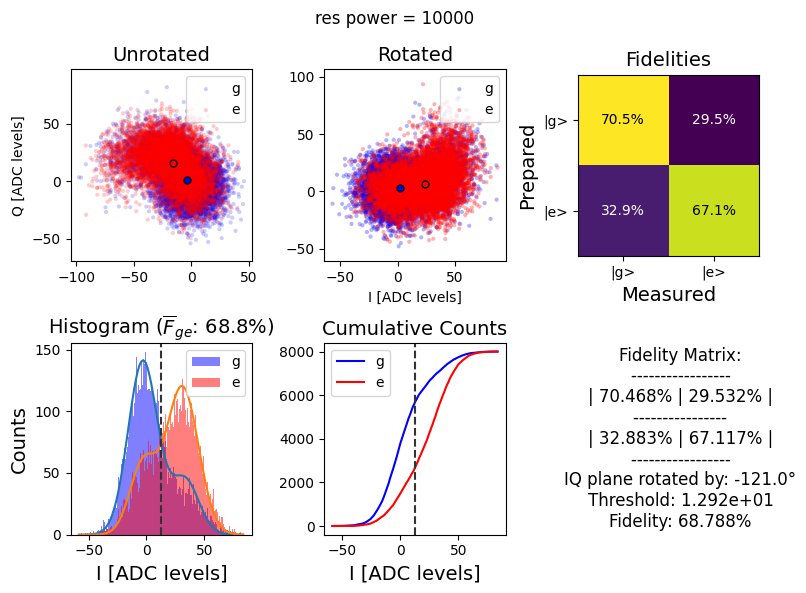

Unrotated:
Ig -4.3824289405684755 +/- 19.726516184468647 	 Qg 1.3255813953488371 +/- 17.95969614765255 	 Amp g 4.5785204438581575 +/- 15.440726052030614
Ie -18.015503875968992 +/- 22.00598391021365 	 Qe 16.910852713178294 +/- 18.346532935456455 	 Amp e 24.7090129182018 +/- 15.16151917644064
Rotated:
Ig 2.721163587805667 +/- 19.726516184468647 	 Qg 3.368588296452548 +/- 17.95969614765255 	 Amp g 4.330371621766022 +/- 15.440726052030614
Ie 26.174034099282455 +/- 22.00598391021365 	 Qe 5.397498810943272 +/- 18.346532935456455 	 Amp e 26.724764815513993 +/- 15.16151917644064
g correctly categorized: 73.0375%
e correctly categorized: 64.4991871951982%

        Fidelity Matrix:
        -----------------
        | 73.037% | 26.962% |
        ----------------
        | 35.525% | 64.475% |
        -----------------
        IQ plane rotated by: -126.2°
        Threshold: 1.667e+01
        Fidelity: 68.768%
        


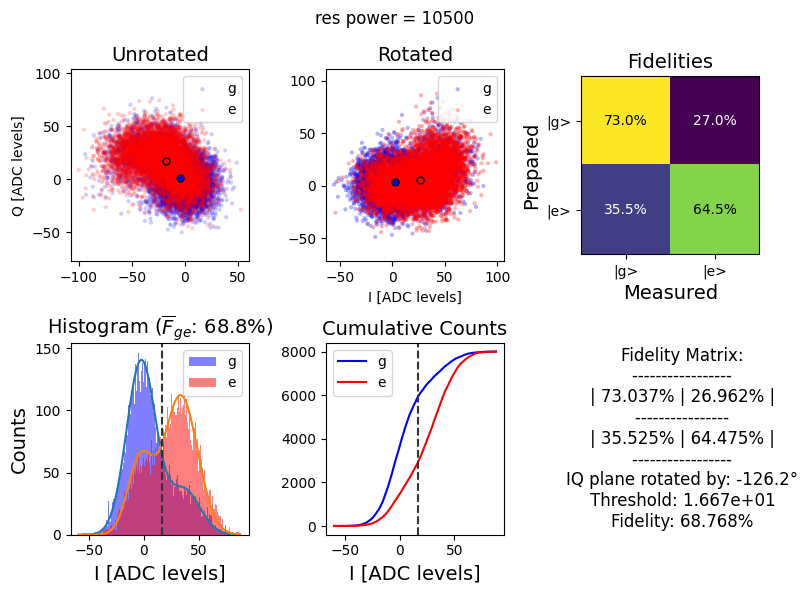

Unrotated:
Ig -4.834625322997416 +/- 20.683856322721116 	 Qg 2.2041343669250644 +/- 18.017502740305076 	 Amp g 5.3133614897941985 +/- 16.30151170706245
Ie -18.713178294573645 +/- 21.99445872153084 	 Qe 17.35658914728682 +/- 18.012988824279837 	 Amp e 25.523209608358755 +/- 15.606926167009414
Rotated:
Ig 3.5866273299801854 +/- 20.683856322721116 	 Qg 3.4362127699295177 +/- 18.017502740305076 	 Amp g 4.967036722673538 +/- 16.30151170706245
Ie 27.147865805792065 +/- 21.99445872153084 	 Qe 5.032702257935985 +/- 18.012988824279837 	 Amp e 27.610409446915636 +/- 15.606926167009414
g correctly categorized: 69.46736684171042%
e correctly categorized: 67.19999999999999%

        Fidelity Matrix:
        -----------------
        | 69.467% | 30.533% |
        ----------------
        | 32.783% | 67.217% |
        -----------------
        IQ plane rotated by: -127.5°
        Threshold: 1.537e+01
        Fidelity: 68.334%
        


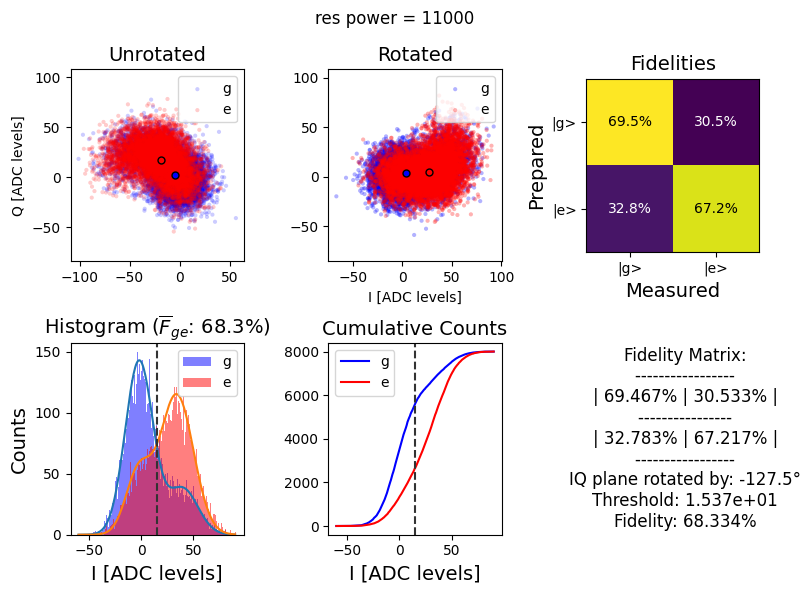

Unrotated:
Ig -5.295865633074936 +/- 21.3431448370363 	 Qg 3.148578811369509 +/- 18.183340038093682 	 Amp g 6.161147728710067 +/- 17.319821222993347
Ie -19.34625322997416 +/- 22.65457917604859 	 Qe 19.124031007751938 +/- 18.40957587467734 	 Amp e 27.203052696779146 +/- 16.467278951784152
Rotated:
Ig 4.674831140756859 +/- 21.3431448370363 	 Qg 2.553386590595233 +/- 18.183340038093682 	 Amp g 5.326709047397053 +/- 17.319821222993347
Ie 29.40843876258092 +/- 22.65457917604859 	 Qe 2.1864772950808717 +/- 18.40957587467734 	 Amp e 29.48960754934484 +/- 16.467278951784152
g correctly categorized: 69.65111916968864%
e correctly categorized: 67.69634817408705%

        Fidelity Matrix:
        -----------------
        | 69.651% | 30.349% |
        ----------------
        | 32.312% | 67.688% |
        -----------------
        IQ plane rotated by: -133.0°
        Threshold: 1.632e+01
        Fidelity: 68.674%
        


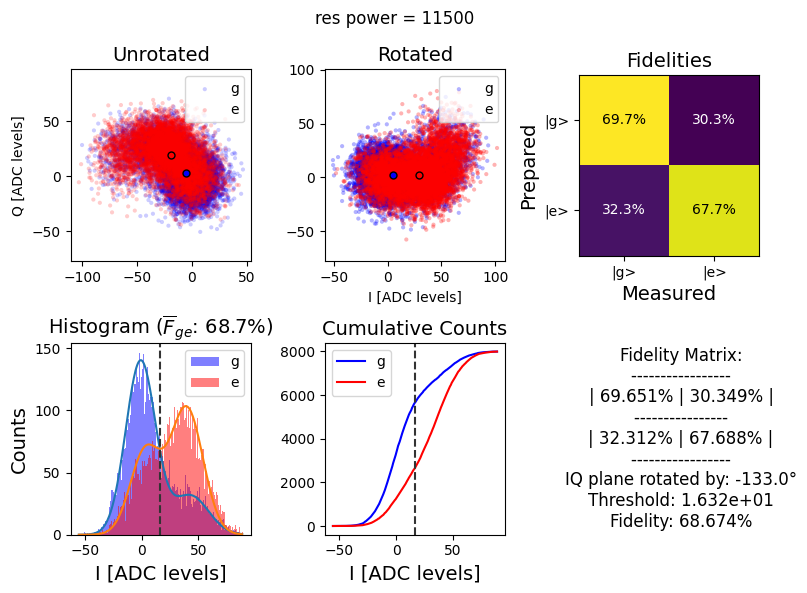

Unrotated:
Ig -6.609819121447028 +/- 21.426479161287876 	 Qg 4.8604651162790695 +/- 18.135655306252357 	 Amp g 8.204500592041692 +/- 17.568102237600016
Ie -19.373385012919897 +/- 22.68916087425928 	 Qe 19.93152454780362 +/- 18.46020730046665 	 Amp e 27.795570108535777 +/- 16.675484098359014
Rotated:
Ig 6.430407167445491 +/- 21.426479161287876 	 Qg 3.346237726389542 +/- 18.135655306252357 	 Amp g 7.248961529808735 +/- 17.568102237600016
Ie 29.963814752227137 +/- 22.68916087425928 	 Qe 4.839737424199902 +/- 18.46020730046665 	 Amp e 30.352154006610235 +/- 16.675484098359014
g correctly categorized: 66.79584948118516%
e correctly categorized: 68.4921230307577%

        Fidelity Matrix:
        -----------------
        | 66.796% | 33.204% |
        ----------------
        | 31.516% | 68.484% |
        -----------------
        IQ plane rotated by: -125.3°
        Threshold: 1.670e+01
        Fidelity: 67.644%
        


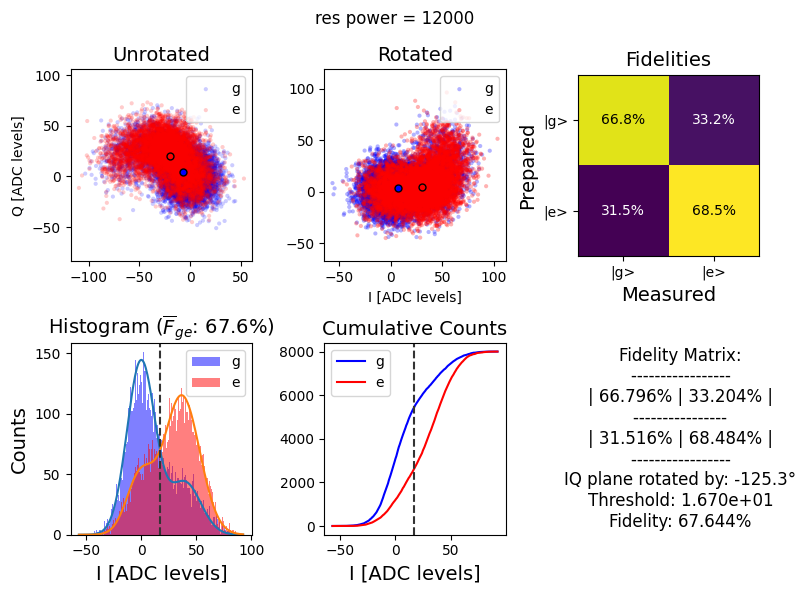

Unrotated:
Ig -8.869509043927648 +/- 22.441569217329953 	 Qg 6.126614987080103 +/- 18.301321824477835 	 Amp g 10.77977745040355 +/- 18.570642181272483
Ie -22.69250645994832 +/- 23.21169144315168 	 Qe 21.558139534883722 +/- 18.31064085379853 	 Amp e 31.30021133539377 +/- 17.394039444292236
Rotated:
Ig 9.470755615832541 +/- 22.441569217329953 	 Qg 4.78156527423061 +/- 18.301321824477835 	 Amp g 10.609362770993915 +/- 18.570642181272483
Ie 33.116195694464196 +/- 23.21169144315168 	 Qe 7.318128590013891 +/- 18.31064085379853 	 Amp e 33.91515035104559 +/- 17.394039444292236
g correctly categorized: 67.55844480560069%
e correctly categorized: 67.62535950981618%

        Fidelity Matrix:
        -----------------
        | 67.558% | 32.442% |
        ----------------
        | 32.392% | 67.608% |
        -----------------
        IQ plane rotated by: -123.5°
        Threshold: 2.129e+01
        Fidelity: 67.592%
        


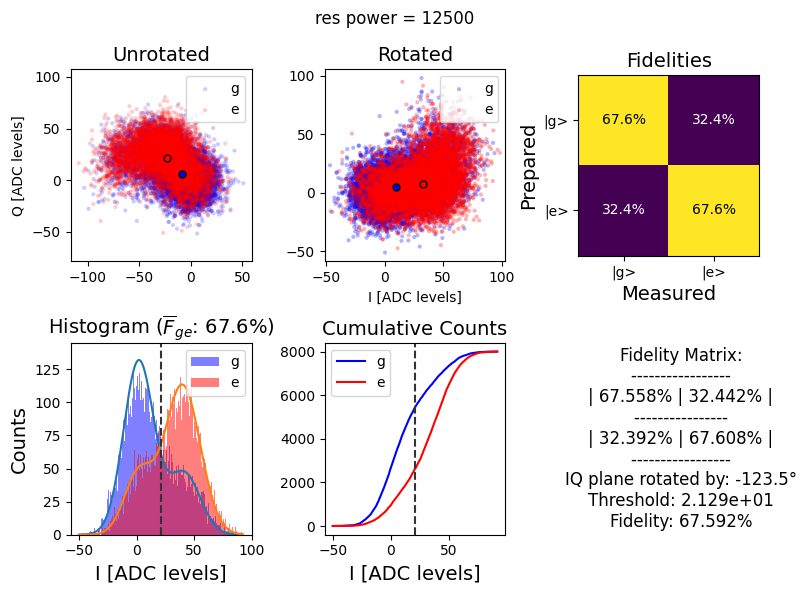

Unrotated:
Ig -8.425064599483203 +/- 21.242834947204667 	 Qg 6.595607235142118 +/- 17.34235438260635 	 Amp g 10.699707860765365 +/- 17.835504680376456
Ie -23.297157622739018 +/- 23.073891021549503 	 Qe 22.847545219638242 +/- 18.370675054232088 	 Amp e 32.63078111020576 +/- 17.04612592651237
Rotated:
Ig 8.917764370044454 +/- 21.242834947204667 	 Qg 5.256689343861302 +/- 17.34235438260635 	 Amp g 10.351777828832075 +/- 17.835504680376456
Ie 33.24691264008864 +/- 23.073891021549503 	 Qe 9.699596109313404 +/- 18.370675054232088 	 Amp e 34.63292313365266 +/- 17.04612592651237
g correctly categorized: 69.68371046380797%
e correctly categorized: 68.53750000000001%

        Fidelity Matrix:
        -----------------
        | 69.684% | 30.316% |
        ----------------
        | 31.454% | 68.546% |
        -----------------
        IQ plane rotated by: -117.5°
        Threshold: 2.108e+01
        Fidelity: 69.111%
        


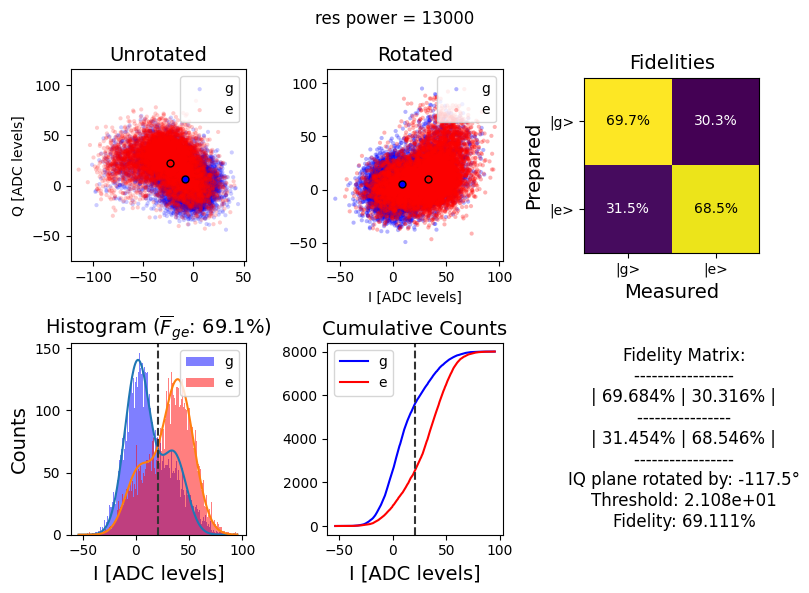

Unrotated:
Ig -15.704134366925064 +/- 23.057349081981062 	 Qg 10.916020671834625 +/- 17.658294639932755 	 Amp g 19.125358650816402 +/- 19.602653276596854
Ie -27.497416020671835 +/- 22.695425919352875 	 Qe 25.031007751937985 +/- 17.511645244479432 	 Amp e 37.18412614129152 +/- 18.00718185053167
Rotated:
Ig 16.89153991809862 +/- 23.057349081981062 	 Qg 9.350732070804936 +/- 17.658294639932755 	 Amp g 19.307001607310728 +/- 19.602653276596854
Ie 36.41411225142285 +/- 22.695425919352875 	 Qe 13.739890248287479 +/- 17.511645244479432 	 Amp e 38.92007393485024 +/- 18.00718185053167
g correctly categorized: 59.88248531066384%
e correctly categorized: 73.075%

        Fidelity Matrix:
        -----------------
        | 59.882% | 40.118% |
        ----------------
        | 26.916% | 73.084% |
        -----------------
        IQ plane rotated by: -114.9°
        Threshold: 2.254e+01
        Fidelity: 66.479%
        


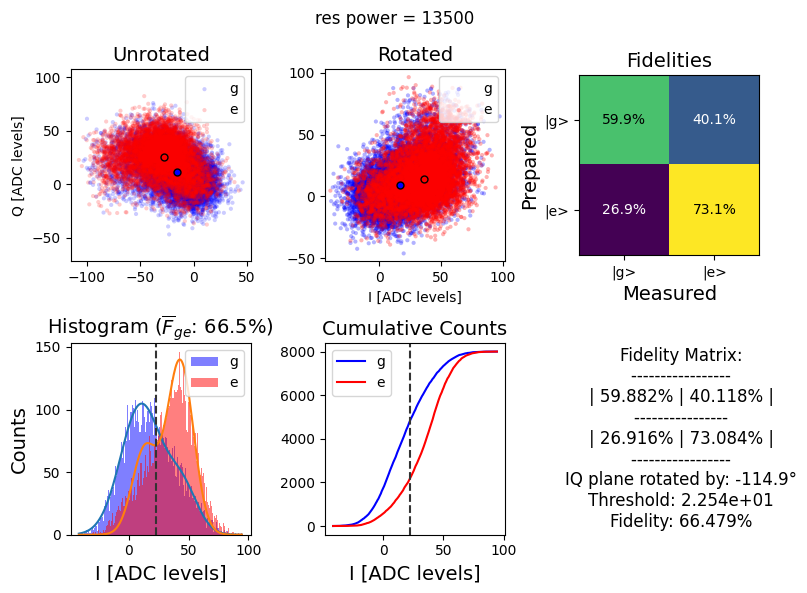

Unrotated:
Ig -29.04263565891473 +/- 23.518744636703442 	 Qg 16.07622739018088 +/- 16.87956832230169 	 Amp g 33.19517695565528 +/- 20.56070155025659
Ie -36.69767441860465 +/- 22.50610568287466 	 Qe 25.54005167958656 +/- 16.658701975678724 	 Amp e 44.71032931582882 +/- 18.69620804859433
Rotated:
Ig 26.92631600366788 +/- 23.518744636703442 	 Qg 18.63674172851356 +/- 16.87956832230169 	 Amp g 32.74682634675763 +/- 20.56070155025659
Ie 39.55999520846252 +/- 22.50610568287466 	 Qe 21.827290792597402 +/- 16.658701975678724 	 Amp e 45.18211863379344 +/- 18.69620804859433
g correctly categorized: 58.844133099824866%
e correctly categorized: 65.67070883860482%

        Fidelity Matrix:
        -----------------
        | 58.844% | 41.156% |
        ----------------
        | 34.288% | 65.712% |
        -----------------
        IQ plane rotated by: -114.0°
        Threshold: 3.193e+01
        Fidelity: 62.257%
        


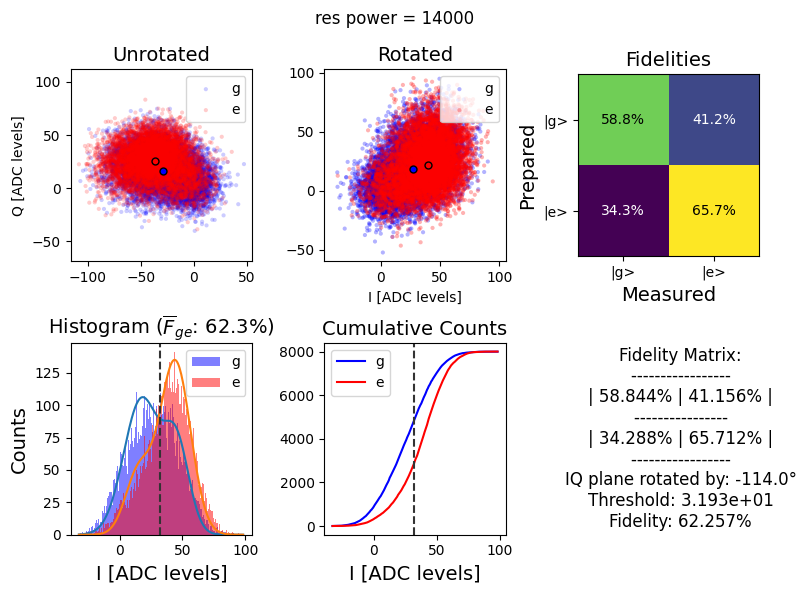

Unrotated:
Ig -38.89147286821705 +/- 22.621605481213496 	 Qg 18.825581395348838 +/- 15.696751074382876 	 Amp g 43.20820728440567 +/- 20.049024897164568
Ie -45.042635658914726 +/- 21.53246564559988 	 Qe 26.308785529715763 +/- 15.858844445845142 	 Amp e 52.16312129417025 +/- 18.627138089609772
Rotated:
Ig 33.23072352638631 +/- 22.621605481213496 	 Qg 26.289078027669767 +/- 15.696751074382876 	 Amp g 42.37212066479602 +/- 20.049024897164568
Ie 42.866055494466835 +/- 21.53246564559988 	 Qe 29.79111079167228 +/- 15.858844445845142 	 Amp e 52.20161870915885 +/- 18.627138089609772
g correctly categorized: 55.94597974240341%
e correctly categorized: 65.75821977747218%

        Fidelity Matrix:
        -----------------
        | 55.946% | 44.054% |
        ----------------
        | 34.225% | 65.775% |
        -----------------
        IQ plane rotated by: -114.4°
        Threshold: 3.602e+01
        Fidelity: 60.852%
        


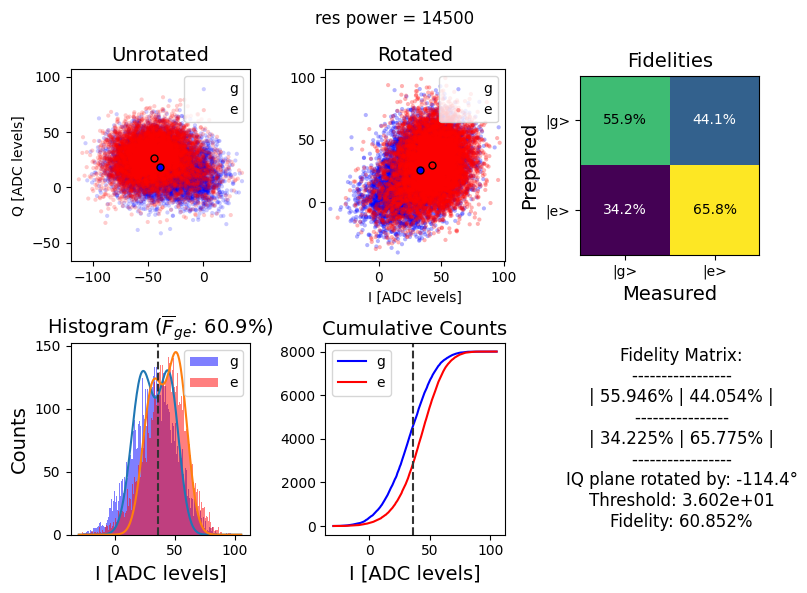

Unrotated:
Ig -43.60852713178295 +/- 22.863822156869784 	 Qg 21.524547803617573 +/- 15.725093984659837 	 Amp g 48.631366387894836 +/- 20.264432749237642
Ie -49.143410852713174 +/- 21.447654212757715 	 Qe 27.325581395348838 +/- 15.944413101628383 	 Amp e 56.22954942761325 +/- 19.012839058406165
Rotated:
Ig 44.2216748213784 +/- 22.863822156869784 	 Qg 19.27085389017456 +/- 15.725093984659837 	 Amp g 48.238183357835815 +/- 20.264432749237642
Ie 52.449510281066104 +/- 21.447654212757715 	 Qe 20.70887878464512 +/- 15.944413101628383 	 Amp e 56.3897933073068 +/- 19.012839058406165
Attempted to init fitparam 1 to 51.67223914462312, which is out of bounds -18.397339316795353 to 48.00192789188216. Instead init to 14.802294287543404
Attempted to init fitparam 1 to 51.67223914462312, which is out of bounds -18.397339316795353 to 48.00192789188216. Instead init to 14.802294287543404
g correctly categorized: 57.31279739544202%
e correctly categorized: 61.15350932065557%

        Fidelity Matrix:
  

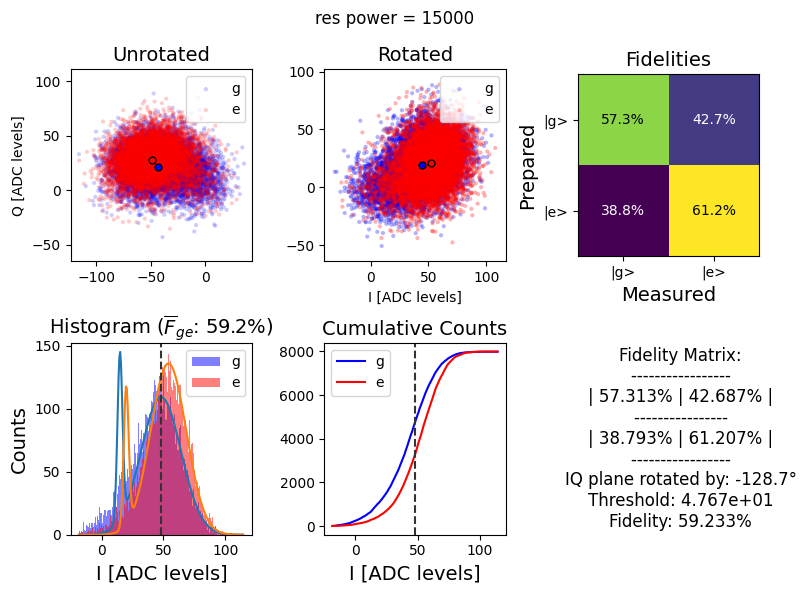

Unrotated:
Ig -47.89276485788114 +/- 24.328938332762878 	 Qg 22.794573643410853 +/- 15.75513403860695 	 Amp g 53.040640204631536 +/- 21.59478711109044
Ie -51.23385012919897 +/- 22.922600139169642 	 Qe 28.61111111111111 +/- 15.667690813496554 	 Amp e 58.68136908826827 +/- 20.1443223708713
Rotated:
Ig 36.564007017972074 +/- 24.328938332762878 	 Qg 37.21253860612067 +/- 15.75513403860695 	 Amp g 52.169911239356466 +/- 21.59478711109044
Ie 42.97466242365453 +/- 22.922600139169642 	 Qe 38.75336578737362 +/- 15.667690813496554 	 Amp e 57.86747765608109 +/- 20.1443223708713
g correctly categorized: 42.3620668084574%
e correctly categorized: 73.12406203101551%

        Fidelity Matrix:
        -----------------
        | 42.362% | 57.638% |
        ----------------
        | 26.848% | 73.152% |
        -----------------
        IQ plane rotated by: -108.2°
        Threshold: 3.297e+01
        Fidelity: 57.743%
        


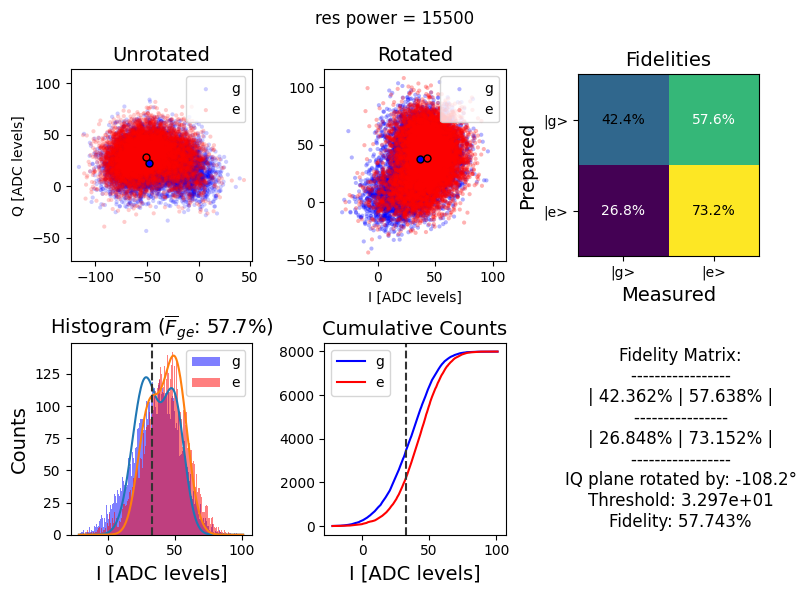

Unrotated:
Ig -51.43023255813954 +/- 23.596128929026044 	 Qg 24.36950904392765 +/- 15.518558809405185 	 Amp g 56.91170171437846 +/- 21.053333158765387
Ie -52.666666666666664 +/- 23.60797594407387 	 Qe 29.170542635658915 +/- 15.200077267589297 	 Amp e 60.20546765399777 +/- 19.843335665425535
Rotated:
Ig 34.67979500296775 +/- 23.596128929026044 	 Qg 44.05225291791308 +/- 15.518558809405185 	 Amp g 56.065044088020194 +/- 21.053333158765387
Ie 39.66053589067161 +/- 23.60797594407387 	 Qe 44.305007465355324 +/- 15.200077267589297 	 Amp e 59.463365138885656 +/- 19.843335665425535
Attempted to init fitparam 1 to 37.741440712187774, which is out of bounds -19.957361089989654 to 36.88452781413564. Instead init to 8.463583362072992
Attempted to init fitparam 1 to 37.741440712187774, which is out of bounds -19.957361089989654 to 36.88452781413564. Instead init to 8.463583362072992
g correctly categorized: 45.46136534133534%
e correctly categorized: 67.71692923230808%

        Fidelity Matrix:
   

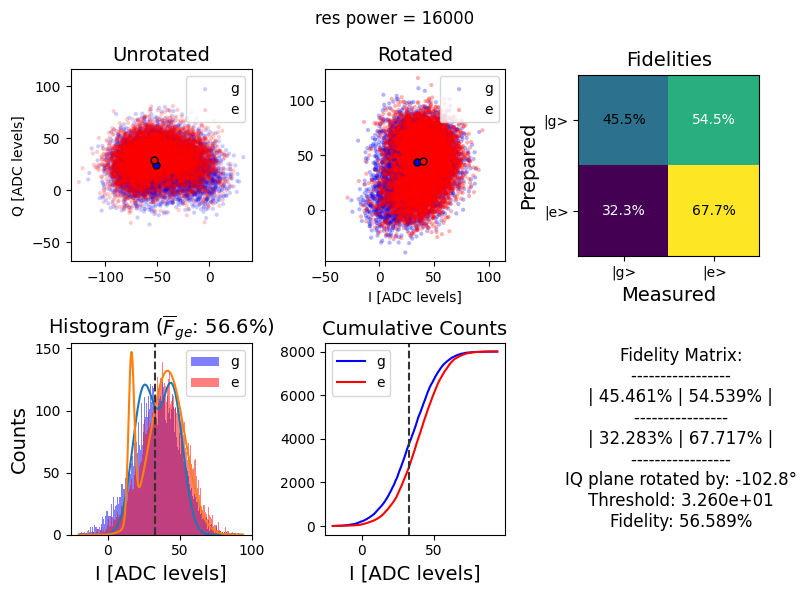

Unrotated:
Ig -54.97416020671835 +/- 23.66359772184917 	 Qg 25.525839793281655 +/- 15.281683980511543 	 Amp g 60.61127607620728 +/- 20.82667872907297
Ie -55.19896640826873 +/- 23.031453521814672 	 Qe 29.521963824289408 +/- 15.164312959829115 	 Amp e 62.59770155991219 +/- 20.070983025114998
Rotated:
Ig 32.91617160013831 +/- 23.66359772184917 	 Qg 50.60435912119887 +/- 15.281683980511543 	 Amp g 60.36783510179088 +/- 20.82667872907297
Ie 36.99334895245289 +/- 23.031453521814672 	 Qe 50.06828537731538 +/- 15.164312959829115 	 Amp e 62.25223744848245 +/- 20.070983025114998
Attempted to init fitparam 1 to 34.9547602762956, which is out of bounds -27.93843353076806 to 34.64029430726028. Instead init to 3.350930388246109
Attempted to init fitparam 1 to 34.9547602762956, which is out of bounds -27.93843353076806 to 34.64029430726028. Instead init to 3.350930388246109
g correctly categorized: 58.66983372921615%
e correctly categorized: 52.156519564945626%

        Fidelity Matrix:
        -----

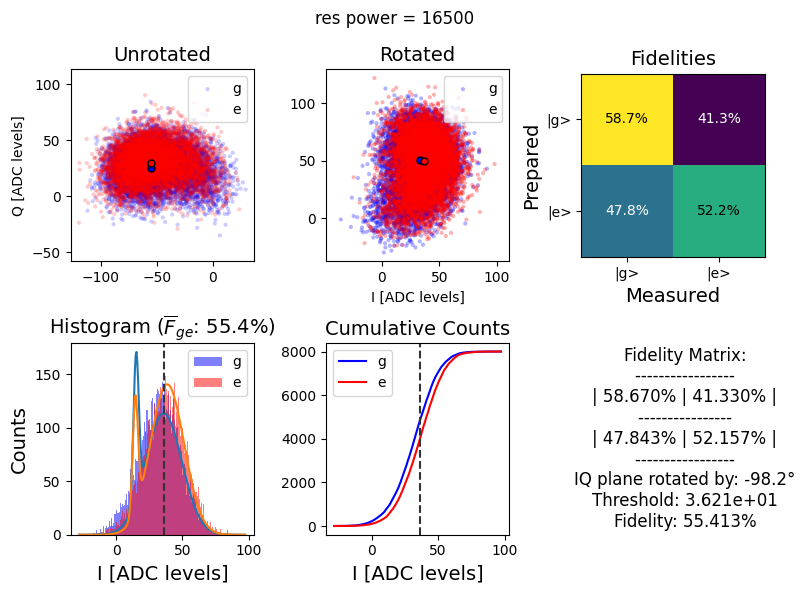

Unrotated:
Ig -56.73255813953489 +/- 25.07021416768538 	 Qg 25.781653746770026 +/- 15.248127583408591 	 Amp g 62.315943569635905 +/- 22.1919860390721
Ie -57.29715762273902 +/- 24.023680383907628 	 Qe 30.214470284237727 +/- 15.19438383984956 	 Amp e 64.77560100996428 +/- 20.699932610437457
Rotated:
Ig 36.62658548715717 +/- 25.07021416768538 	 Qg 49.28836590653961 +/- 15.248127583408591 	 Amp g 61.40724532321059 +/- 22.1919860390721
Ie 41.2726910622473 +/- 24.023680383907628 	 Qe 48.939730629930565 +/- 15.19438383984956 	 Amp e 64.01978023743813 +/- 20.699932610437457
Attempted to init fitparam 4 to 37.76924051235803, which is out of bounds 38.65453883411619 to 97.37932751074041. Instead init to 68.0169331724283
Attempted to init fitparam 4 to 37.76924051235803, which is out of bounds 38.65453883411619 to 97.37932751074041. Instead init to 68.0169331724283
g correctly categorized: 51.225612806403205%
e correctly categorized: 60.80760095011877%

        Fidelity Matrix:
        ----------

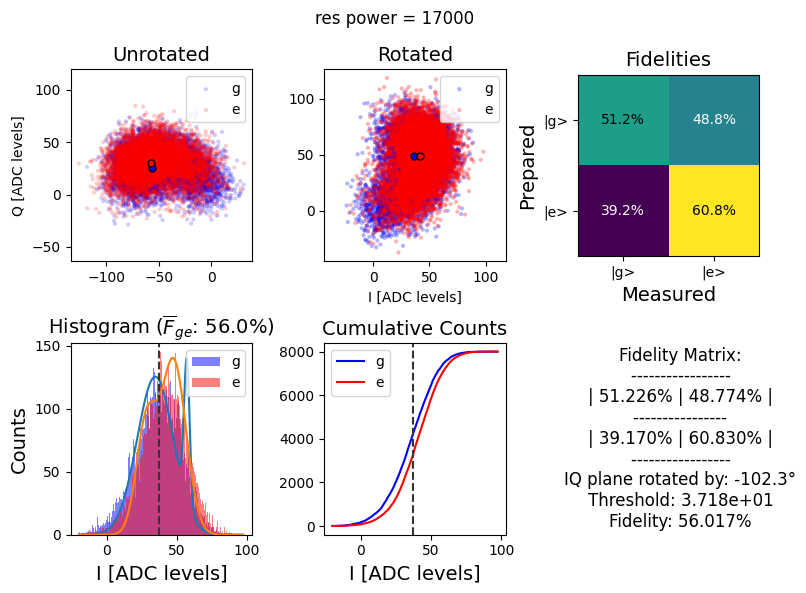

Unrotated:
Ig -60.40439276485788 +/- 25.8224225157624 	 Qg 26.990956072351423 +/- 15.252050631789238 	 Amp g 66.16042907199756 +/- 22.884160285213888
Ie -58.746770025839794 +/- 24.84250238220686 	 Qe 30.684754521963825 +/- 15.323954766079886 	 Amp e 66.27772739421658 +/- 21.197855642156853
Rotated:
Ig 17.763543231431598 +/- 25.8224225157624 	 Qg 64.19332798016933 +/- 15.252050631789238 	 Amp g 66.60575669793512 +/- 22.884160285213888
Ie 21.475694203421657 +/- 24.84250238220686 	 Qe 63.27885633237247 +/- 15.323954766079886 	 Amp e 66.8237914238029 +/- 21.197855642156853
g correctly categorized: 61.487500000000004%
e correctly categorized: 48.25000000000001%

        Fidelity Matrix:
        -----------------
        | 61.488% | 38.513% |
        ----------------
        | 51.750% | 48.250% |
        -----------------
        IQ plane rotated by: -80.8°
        Threshold: 2.228e+01
        Fidelity: 54.869%
        


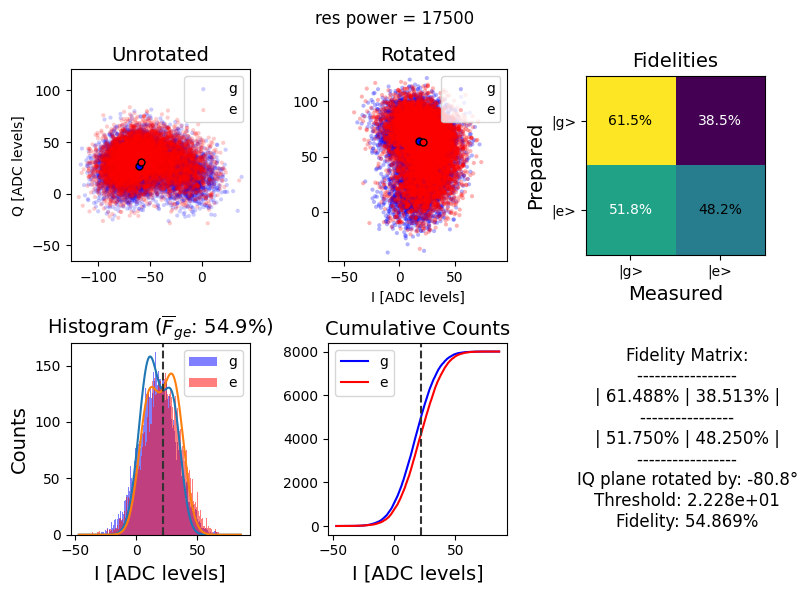

Unrotated:
Ig -60.75710594315245 +/- 27.66337771731096 	 Qg 27.05426356589147 +/- 15.127455401078205 	 Amp g 66.50833857254422 +/- 24.31336194173498
Ie -60.20413436692507 +/- 26.229709907626045 	 Qe 30.990956072351423 +/- 15.45921766908547 	 Amp e 67.71245936420553 +/- 22.850340659141974
Rotated:
Ig 27.356678123684212 +/- 27.66337771731096 	 Qg 60.54155850835059 +/- 15.127455401078205 	 Amp g 66.43544343633826 +/- 24.31336194173498
Ie 31.31729066972816 +/- 26.229709907626045 	 Qe 60.018870081644806 +/- 15.45921766908547 	 Amp e 67.69813483966601 +/- 22.850340659141974
g correctly categorized: 53.37499999999999%
e correctly categorized: 56.6125%

        Fidelity Matrix:
        -----------------
        | 53.375% | 46.625% |
        ----------------
        | 43.388% | 56.612% |
        -----------------
        IQ plane rotated by: -90.3°
        Threshold: 2.870e+01
        Fidelity: 54.994%
        


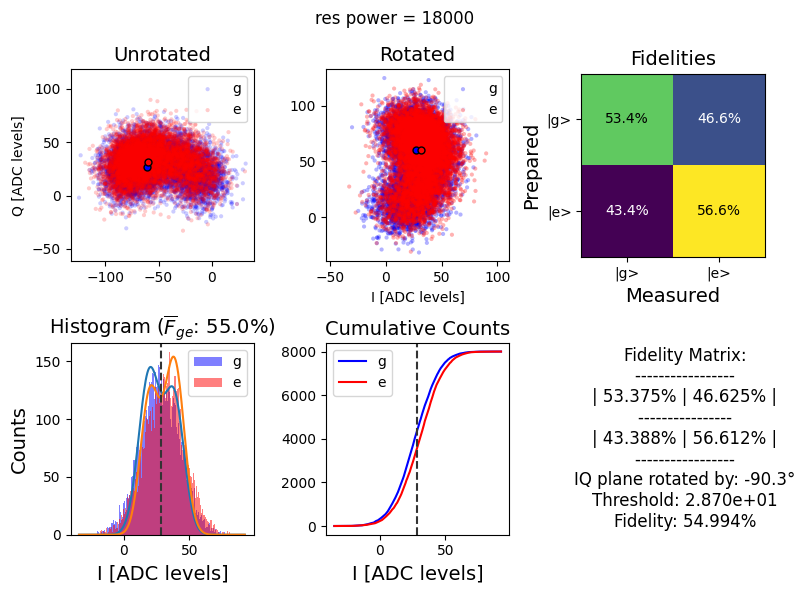

Unrotated:
Ig -61.73385012919897 +/- 28.588903139851208 	 Qg 27.776485788113696 +/- 15.329085524765116 	 Amp g 67.69491424406772 +/- 25.145857364574347
Ie -60.593023255813954 +/- 28.006382775782743 	 Qe 31.113695090439276 +/- 15.20422553085721 	 Amp e 68.11443671836709 +/- 23.278842596440278
Rotated:
Ig 24.057445919290238 +/- 28.588903139851208 	 Qg 63.72484754759848 +/- 15.329085524765116 	 Amp g 68.11473334840446 +/- 25.145857364574347
Ie 27.383961788640626 +/- 28.006382775782743 	 Qe 62.871408331912136 +/- 15.20422553085721 	 Amp e 68.57620103855098 +/- 23.278842596440278
Attempted to init fitparam 1 to 25.720703853965432, which is out of bounds -44.89662446949308 to 25.367617212348136. Instead init to -9.76450362857247
Attempted to init fitparam 1 to 25.720703853965432, which is out of bounds -44.89662446949308 to 25.367617212348136. Instead init to -9.76450362857247
g correctly categorized: 56.3125%
e correctly categorized: 52.425%

        Fidelity Matrix:
        ---------------

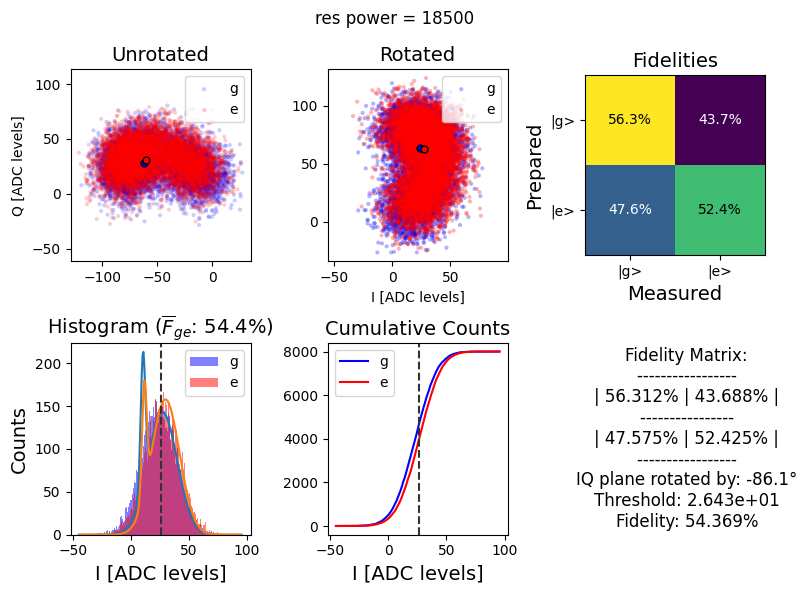

Unrotated:
Ig -60.95607235142119 +/- 29.364536208578144 	 Qg 28.45219638242894 +/- 15.177738846941345 	 Amp g 67.26938557394439 +/- 25.815907371589333
Ie -61.17700258397933 +/- 28.79308111048821 	 Qe 31.266149870801033 +/- 15.108423194120485 	 Amp e 68.70369548214714 +/- 24.017099664867526
Rotated:
Ig 21.3327531852671 +/- 29.364536208578144 	 Qg 64.5048792463777 +/- 15.177738846941345 	 Amp g 67.94089935416878 +/- 25.815907371589333
Ie 24.228609162532678 +/- 28.79308111048821 	 Qe 65.17761155037486 +/- 15.108423194120485 	 Amp e 69.53521805072823 +/- 24.017099664867526
Attempted to init fitparam 1 to 23.419818190453654, which is out of bounds -41.13302048147547 to 22.46111266562302. Instead init to -9.335953907926225
Attempted to init fitparam 4 to 20.863270124238632, which is out of bounds 22.46111266562302 to 86.05524581272151. Instead init to 54.258179239172264
Attempted to init fitparam 1 to 23.419818190453654, which is out of bounds -41.13302048147547 to 22.46111266562302. Instead

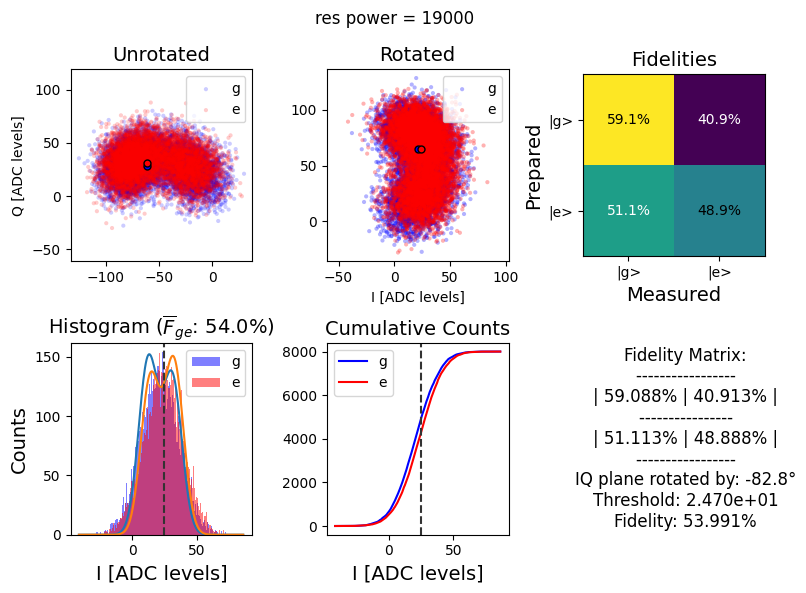

Unrotated:
Ig -61.62144702842377 +/- 30.010112736134303 	 Qg 29.370801033591732 +/- 15.249867711541336 	 Amp g 68.26306971731985 +/- 26.771963049572918
Ie -61.93798449612403 +/- 29.210869647375947 	 Qe 32.13178294573643 +/- 15.309821799278868 	 Amp e 69.7765390279141 +/- 24.510774727721518
Rotated:
Ig 20.838528394280583 +/- 30.010112736134303 	 Qg 65.96071133535537 +/- 15.249867711541336 	 Amp g 69.174125982952 +/- 26.771963049572918
Ie 23.642604292413694 +/- 29.210869647375947 	 Qe 66.71512139634171 +/- 15.309821799278868 	 Amp e 70.78050692568026 +/- 24.510774727721518
g correctly categorized: 54.0875%
e correctly categorized: 53.956744593074134%

        Fidelity Matrix:
        -----------------
        | 54.087% | 45.913% |
        ----------------
        | 46.050% | 53.950% |
        -----------------
        IQ plane rotated by: -81.5°
        Threshold: 2.224e+01
        Fidelity: 54.022%
        


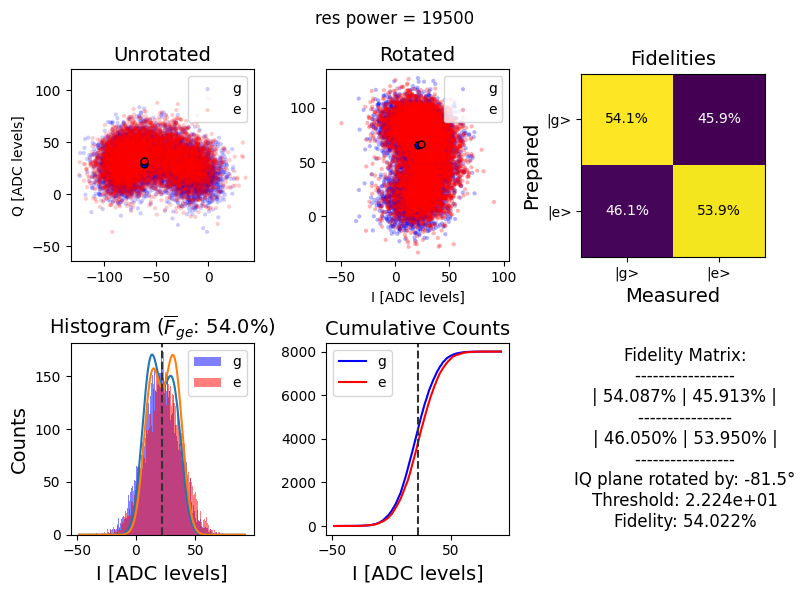

In [86]:
from pathlib import Path
gain_list = np.arange(2000, 20000, 500)
dist=[]
for idx, gain in enumerate(gain_list):
    shot = f"q2 single shot with twpa, gain={gain}.hdf5"
    path = Path(r"D:\Jay PhD\Code\data_fitting\data\singleshot") / shot
    shot = Labber.LogFile(path)
    g = shot.getData()[0]
    e = shot.getData()[1]

    Ig, Qg = g.real, g.imag
    Ie, Qe = e.real, e.imag
    dataset =[Ig, Qg, Ie, Qe]
    
    _, _, _, popt = histtests(data=dataset, fid_avg=True, b_plot=True, b_print=True, fit=True, title=f'res power = {gain}')
    dist.append(popt[0][1]-popt[1][4])

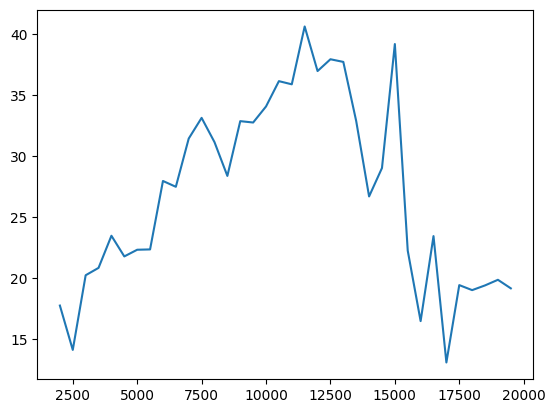

In [55]:
plt.plot(gain_list, np.abs(dist))

Unrotated:
Ig -60.95607235142119 +/- 29.364536208578144 	 Qg 28.45219638242894 +/- 15.177738846941345 	 Amp g 67.26938557394439 +/- 25.815907371589333
Ie -61.17700258397933 +/- 28.79308111048821 	 Qe 31.266149870801033 +/- 15.108423194120485 	 Amp e 68.70369548214714 +/- 24.017099664867526
Rotated:
Ig 21.3327531852671 +/- 29.364536208578144 	 Qg 64.5048792463777 +/- 15.177738846941345 	 Amp g 67.94089935416878 +/- 25.815907371589333
Ie 24.228609162532678 +/- 28.79308111048821 	 Qe 65.17761155037486 +/- 15.108423194120485 	 Amp e 69.53521805072823 +/- 24.017099664867526
Attempted to init fitparam 1 to 23.419818190453654, which is out of bounds -41.13302048147547 to 22.46111266562302. Instead init to -9.335953907926225
Attempted to init fitparam 4 to 20.863270124238632, which is out of bounds 22.46111266562302 to 86.05524581272151. Instead init to 54.258179239172264
Attempted to init fitparam 1 to 23.419818190453654, which is out of bounds -41.13302048147547 to 22.46111266562302. Instead

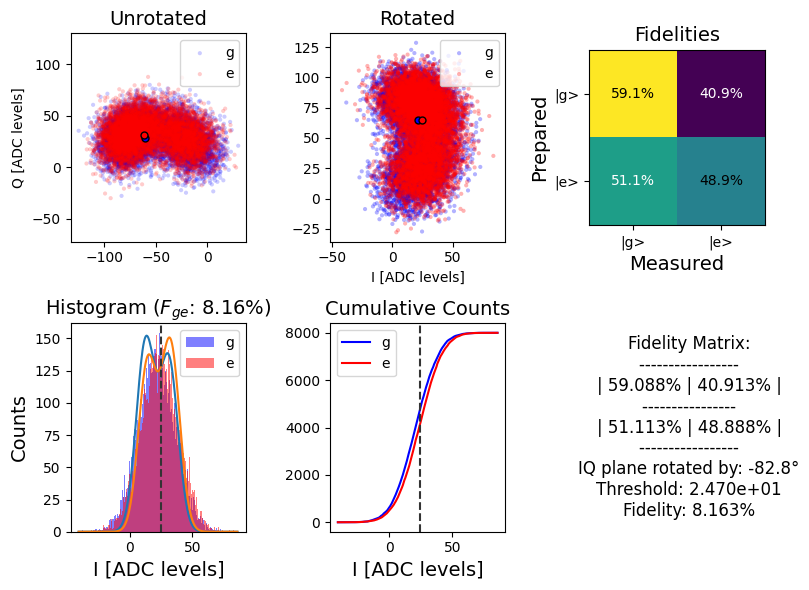

In [72]:
from pathlib import Path
gain_list = np.arange(2000, 20000, 500)

shot = f"q2 single shot with twpa, gain={19000}.hdf5"
path = Path(r"D:\Jay PhD\Code\data_fitting\data\singleshot") / shot
shot = Labber.LogFile(path)
g = shot.getData()[0]
e = shot.getData()[1]

Ig, Qg = g.real, g.imag
Ie, Qe = e.real, e.imag
dataset =[Ig, Qg, Ie, Qe]

_, _, _, popt = histtests(data=dataset, b_plot=True, b_print=True, fit=True)
dist.append(popt[0][1]-popt[1][4])

In [73]:

import scipy as sp
import numpy as np

BIN_NUM=200
# fit data to a 2D Gaussian
def Gaussian2D(xy, xo, yo, sigma):
    x, y = xy
    amplitude = 1 / (2 * np.pi * sigma**2)
    g = amplitude * np.exp(-((x - xo) ** 2 + (y - yo) ** 2) / (2 * sigma**2))

    return g.ravel()


def DualGaussian2D(xy, xo0, yo0, sigma0, xo1, yo1, sigma1, a_ratio):
    A, B = a_ratio, 1 - a_ratio
    return A * Gaussian2D(xy, xo0, yo0, sigma0) + B * Gaussian2D(xy, xo1, yo1, sigma1)


X_LEN, Y_LEN = 100, 100


def fit_data(X: np.ndarray, Y: np.ndarray, D: np.ndarray):
    # initial guess
    max_id = np.argmax(D)
    x_max, y_max = X[max_id], Y[max_id]
    x_mean = np.mean(X)
    y_mean = np.mean(Y)
    sigma = (np.std(X) + np.std(Y)) / 2

    x0 = x_max
    y0 = y_max
    x1 = 2 * x_mean - x_max
    y1 = 2 * y_mean - y_max

    p0 = (x0, y0, 0.5 * sigma, x1, y1, 0.5 * sigma, 0.8)

    # fit
    param, _ = sp.optimize.curve_fit(
        DualGaussian2D,
        (X, Y),
        D,
        p0=p0,
        bounds=(
            [
                x0 - 2.5 * sigma,
                y0 - 2.5 * sigma,
                0,
                x1 - 5 * sigma,
                x1 - 5 * sigma,
                0,
                0.6,
            ],
            [
                x0 + 2.5 * sigma,
                y0 + 2.5 * sigma,
                sigma,
                x1 + 5 * sigma,
                y1 + 5 * sigma,
                sigma,
                1.0,
            ],
        ),
    )

    return param


# change coordinate to make two fit center align with x-axis
def rotate(x, y, angle):
    x_rot = x * np.cos(angle) + y * np.sin(angle)
    y_rot = -x * np.sin(angle) + y * np.cos(angle)

    return x_rot, y_rot


def rotate_data(X0, Y0, param0, X1, Y1, param1):
    center00 = np.array([param0[0], param0[1]])
    center01 = np.array([param0[3], param0[4]])
    center10 = np.array([param1[0], param1[1]])
    center11 = np.array([param1[3], param1[4]])

    angle = np.arctan2(center10[1] - center00[1], center10[0] - center00[0])

    X0_rot, Y0_rot = rotate(X0, Y0, angle)
    X1_rot, Y1_rot = rotate(X1, Y1, angle)

    param0_rot = list(param0)
    param0_rot[0], param0_rot[1] = rotate(center00[0], center00[1], angle)
    param0_rot[3], param0_rot[4] = rotate(center01[0], center01[1], angle)

    param1_rot = list(param1)
    param1_rot[0], param1_rot[1] = rotate(center10[0], center10[1], angle)
    param1_rot[3], param1_rot[4] = rotate(center11[0], center11[1], angle)

    return angle, X0_rot, Y0_rot, param0_rot, X1_rot, Y1_rot, param1_rot


# calculate density of points by kde
def calculate_density(X, Y, bandwidth: float = 0.1):
    return sp.stats.gaussian_kde([X, Y], bw_method=bandwidth)([X, Y])


def calculate_histogram(X0, X1, BIN_NUM):
    bins = np.linspace(min(min(X0), min(X1)), max(max(X0), max(X1)), BIN_NUM)
    dbin = bins[1] - bins[0]
    hist0, _ = np.histogram(X0, bins=bins, density=True)
    hist1, _ = np.histogram(X1, bins=bins, density=True)

    return bins, hist0, hist1


def calculate_threshold(bins, hist0, hist1):
    contrast = np.abs(
        (np.cumsum(hist0) - np.cumsum(hist1)) /
        (0.5 * hist0.sum() + 0.5 * hist1.sum())
    )

    tind = np.argmax(contrast)
    threshold = (bins[tind] + bins[tind + 1]) / 2
    fid = contrast[tind]

    return fid, threshold


def Gaussian1D(x, xo, sigma):
    amplitude = 1 / (sigma * np.sqrt(2 * np.pi))
    g = amplitude * np.exp(-((x - xo) ** 2) / (2 * sigma**2))

    return g


def DualGaussian1D(x, xo0, sigma0, xo1, sigma1, a_ratio):
    A, B = a_ratio, 1 - a_ratio
    return A * Gaussian1D(x, xo0, sigma0) + B * Gaussian1D(x, xo1, sigma1)


def Gaussian1D(x, xo, sigma, amplitude):
    """1D Gaussian with specified amplitude."""
    g = amplitude * np.exp(-((x - xo) ** 2) / (2 * sigma**2))
    return g


def DualGaussian1D(x, xo0, sigma0, amp0, xo1, sigma1, amp1):
    """Sum of two 1D Gaussians with specified amplitudes."""
    g0 = Gaussian1D(x, xo0, sigma0, amp0)
    g1 = Gaussian1D(x, xo1, sigma1, amp1)
    return g0 + g1
    
def plot_histogram2(bins, hist0, hist1, param0, param1, threshold):
    _, ax = plt.subplots()

    # plot histogram and threshold
    ax.bar(bins[:-1], hist0, width=bins[1] -
           bins[0], alpha=0.5, label="State 0")
    ax.bar(bins[:-1], hist1, width=bins[1] -
           bins[0], alpha=0.5, label="State 1")
    ax.axvline(threshold, color="black", linestyle="--", label="Threshold")

    # plot fitting curve
    def Gaussian1D(x, xo, sigma):
        amplitude = 1 / (sigma * np.sqrt(2 * np.pi))
        g = amplitude * np.exp(-((x - xo) ** 2) / (2 * sigma**2))

        return g

    def DualGaussian1D(x, xo0, sigma0, xo1, sigma1, a_ratio):
        A, B = a_ratio, 1 - a_ratio
        return A * Gaussian1D(x, xo0, sigma0) + B * Gaussian1D(x, xo1, sigma1)

    x = np.linspace(min(bins), max(bins), BIN_NUM)

    fit0 = DualGaussian1D(x, param0[0], param0[2], param0[3], param0[5], param0[6]) * (
        x[1] - x[0]
    )
    fit1 = DualGaussian1D(x, param1[0], param1[2], param1[3], param1[5], param1[6]) * (
        x[1] - x[0]
    )

    ax.plot(x, fit0, color="blue", label="Fit 0")
    ax.plot(x, fit1, color="red", label="Fit 1")

    ax.set_xlabel("X")
    ax.set_ylabel("Density")
    ax.legend()

    plt.show()

Fit 0: [-74.03298274  30.165339    14.35965918 -23.41227867  26.64867017
  16.97533599   0.60870758]
Fit 1: [-74.23456821  32.82952185  15.19916806 -24.37035049  29.6010009
  15.34280364   0.63486532]


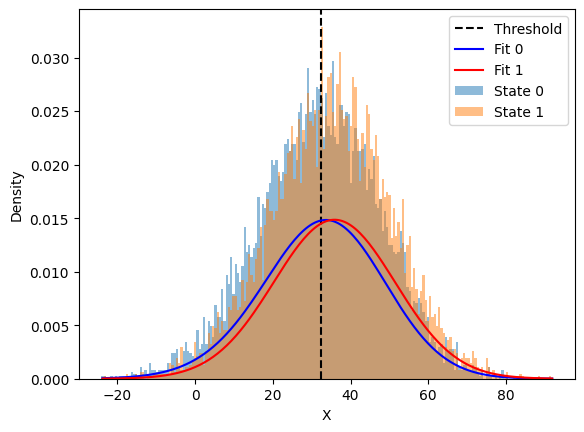

Angle:  1.65 (rad)
Threshold:  32.29
Fidelity:  0.078


In [74]:
BIN_NUM=200
D0 = calculate_density(Ig, Qg)
D1 = calculate_density(Ie, Qe)

param0 = fit_data(Ig, Qg, D0)
param1 = fit_data(Ie, Qe, D1)
print(f"Fit 0: {param0}")
print(f"Fit 1: {param1}")

angle, rX0, rY0, rparam0, rX1, rY1, rparam1 = rotate_data(
    Ig, Qg, param0, Ie, Qe, param1
)
bins, hist0, hist1 = calculate_histogram(rX0, rX1, 200)
fidelity, threshold = calculate_threshold(bins, hist0, hist1)
plot_histogram2(bins, hist0, hist1, rparam0, rparam1, threshold)
print(f"Angle: {angle: .2f} (rad)")
print(f"Threshold: {threshold: .2f}")
print(f"Fidelity: {fidelity: .3f}")
